# Bilateral International Migration prediction using Deep Learning #
### Model variant: manually filtering features and adding engineered features ###


Ludwig-Maximilians-Universität M.Economics Machine Learning Applications - WS2020/21 Term Paper

Code by: Yunting LIU,  15.03.2021

## Note ##

For an introduction to the research topic and methodology see accompanying document "Notes to exam project_bilateral migration prediction". This notebook is an extension to the base notebook "Exam_bilateral_migration_predictions_deep_learning"

# Initialising

In [1]:
import os
import wget
from pathlib import Path

import pandas as pd
import numpy as np
import xarray
#import pandas_profiling

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from pytorch_tabnet.metrics import Metric

import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score 
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


import xgboost as xgb
from typing import Tuple
from xgboost import XGBRegressor

import shap
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999



/Users/jacqueline/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/jacqueline/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Set a random seed to ensure result reproducibility
import random as python_random
random_seed = 123
np.random.seed(random_seed)
python_random.seed(random_seed)
tf.random.set_seed(random_seed)



In [3]:
# Change current working directory for convenience

os.chdir('/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper


# Data

The main data set is made available from [2] and downloaded on the following website : [https://www.sciencedirect.com/science/article/pii/S0304387819304900](https://www.sciencedirect.com/science/article/pii/S0304387819304900)

For convenience i have downloaded a copy of this in my local directory.

## Data import 

In [4]:
os.getcwd()

'/Users/jacqueline/Documents/Study/LMU/2020WS/Machine Learning Applications/exam_paper'

In [5]:
data_in = pd.read_stata('./data/replication_bilateral.dta')

In [6]:
# skip data columns with "GTI" - these relate to internet search keywords which I wish to exclude for this first modelling
# further skip all the log transformation columns
exclude_log_cols = ['o_log_pop', 'd_log_pop', 'o_log_gdp', 'd_log_gdp', 'log_mig_stock']
cols = [c for c in data_in.columns if (c.lower()[:3] != 'gti' and c.lower() not in exclude_log_cols)]

data=data_in[cols].copy()

data

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776


In [7]:
data.shape

(23947, 29)

In [8]:
data.dtypes

pair_id                  int32
iso3n_o                  int32
iso3n_d                  int32
year                     int32
source_country          object
iso3_o                  object
iso3_d                  object
log_mig                float32
fwd_log_mig            float32
o_sl_uem_totl_zs       float32
o_sp_pop_0014_to_zs    float32
sfi_sfi                float64
pol4_autoc             float64
o_IT_CEL_SETS_P2       float64
o_IT_NET_USER_P2       float64
o_number_weather          int8
o_number_nonweather       int8
mig_stock_tot          float32
o_French               float64
o_Spanish              float64
o_English              float64
d_GDP                  float32
d_pop                  float32
o_GDP                  float32
o_pop                  float32
tot_mig                float32
fwd_tot_mig            float32
iso3n_oXyear             int32
iso3n_dXyear             int32
dtype: object

## Data Exploration 

In [9]:
# take a look into a random subset of data
# pandas_profiling.ProfileReport(data.sample(n = 5000, random_state = 123))

# Model Training 

## Data preparation for modelling, split and feature selection 

In [10]:
data_modelling = data

# use log(migration) as model target; this forces models to always predict a positive value for migration
target = 'fwd_log_mig' 

unused_feat = ['paid_id', 'iso3_o', 'iso3_d', 'Set', 'iso3n_o', 'iso3n_d', 'source_country', 'iso3n_oXyear', 'iso3n_dXyear', 'tot_mig', 'log_mig', 'fwd_tot_mig', 
               'd_GDP', 'o_GDP', 'o_French', 'o_Spanish', 'o_English']

eng_feat = ['o_gdp_percapita', 'd_gdp_percapita', 'o_mainlanguage'] 

data_modelling['o_gdp_percapita'] = data_modelling.apply(lambda x: 0 if x.o_pop == 0 else x.o_GDP / x.o_pop, axis = 1) 
data_modelling['d_gdp_percapita'] = data_modelling.apply(lambda x: 0 if x.d_pop == 0 else x.d_GDP / x.d_pop, axis = 1) 
data_modelling['o_mainlanguage'] = data_modelling.apply(lambda x: 'French' if x.o_French > 0.51 else 'Spanish' if x.o_Spanish > 0.51 else 'English' if x.o_English > 0.51 else 'Others', axis = 1) 

features = [ col for col in data_modelling.columns if col not in unused_feat+[target]] 
col_used = features + [target]

In [11]:
data_modelling

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear,o_gdp_percapita,d_gdp_percapita,o_mainlanguage
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.00,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144,5.270861,33.374057,Spanish
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.00,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180,5.694424,33.995874,Spanish
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.00,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216,6.108434,34.499835,Spanish
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.00,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252,6.527160,35.574151,Spanish
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.00,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288,6.659227,36.159245,Spanish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,716,752,2010,Zimbabwe,ZWE,SWE,3.178054,3.433987,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,0.0,0.00,0.42,420.871033,9.378126,5.202304,13.973897,24.000000,29.999998,1439160,1511520,0.372287,44.877945,Others
23943,7021,716,752,2011,Zimbabwe,ZWE,SWE,3.433987,3.295837,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,0.0,0.00,0.42,432.084076,9.449212,5.821660,14.255593,30.999998,26.000002,1439876,1512272,0.408377,45.726995,Others
23944,7021,716,752,2012,Zimbabwe,ZWE,SWE,3.295837,2.772589,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,0.0,0.00,0.42,430.846985,9.519374,6.436730,14.565481,27.000002,15.000000,1440592,1513024,0.441917,45.260013,Others
23945,7021,716,752,2013,Zimbabwe,ZWE,SWE,2.772589,3.688879,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,0.0,0.00,0.42,436.371979,9.600380,6.725359,14.898092,16.000000,39.000000,1441308,1513776,0.451424,45.453616,Others


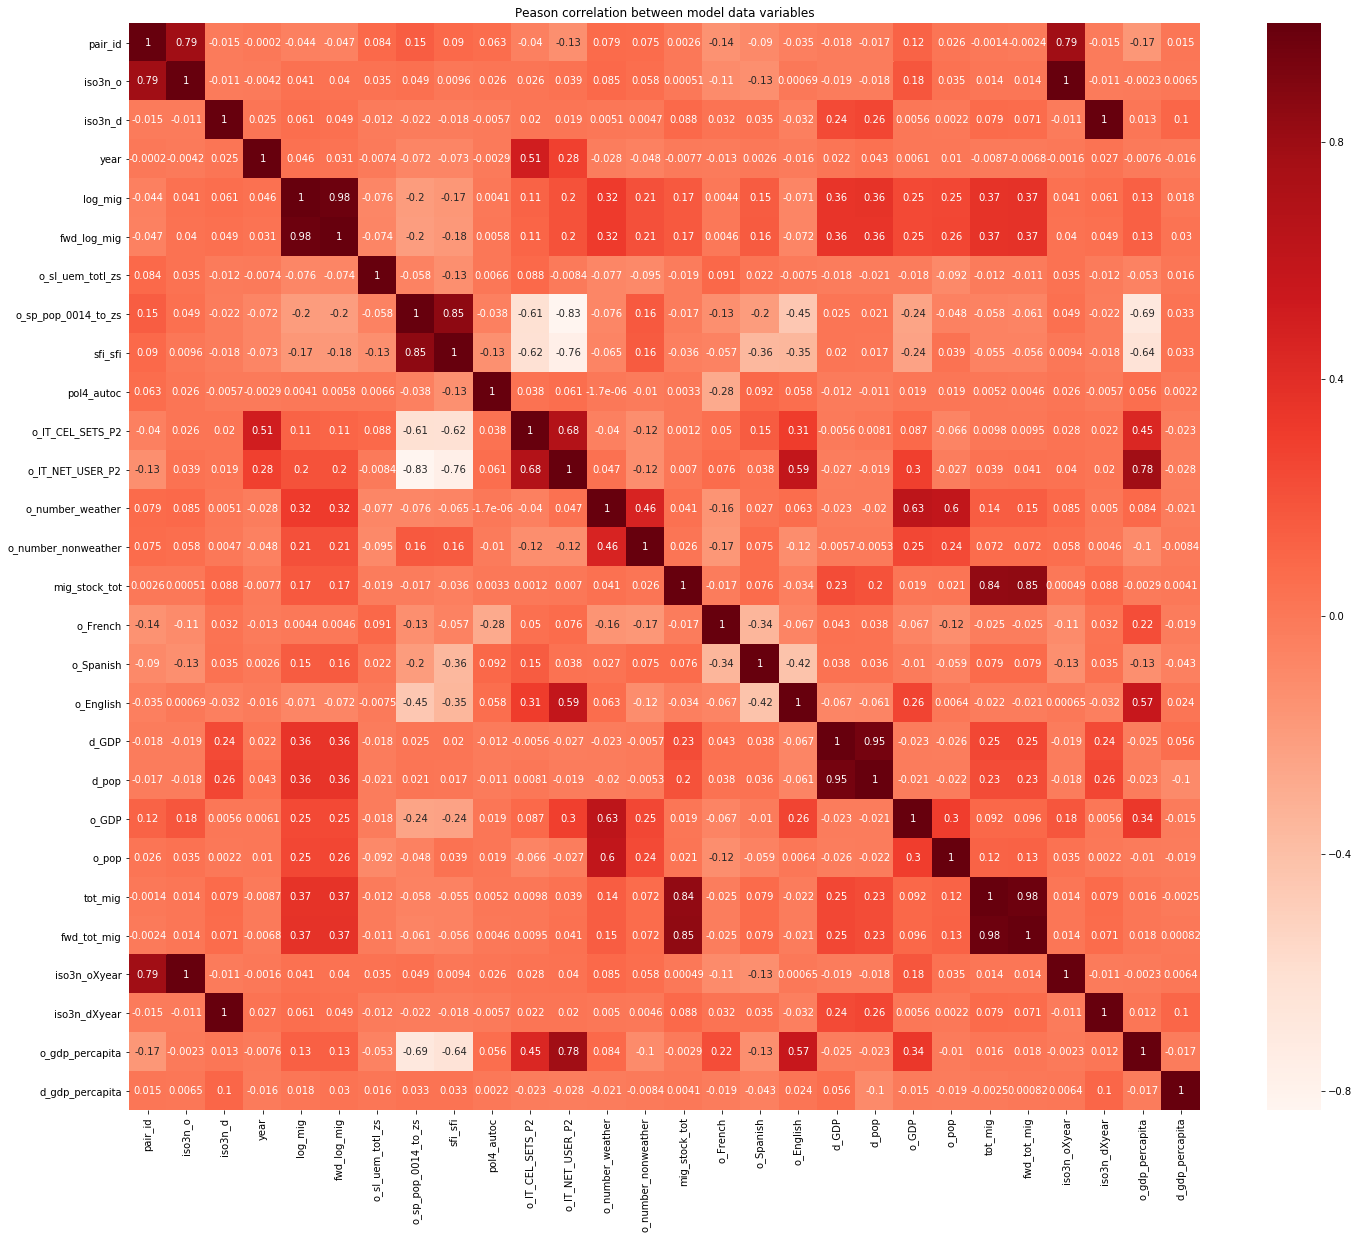

In [12]:
# Check correlation on modelling data (using Pearson Correlation)
cor = data_modelling.corr()

plt.figure(figsize=(24,20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    
plt.title('Peason correlation between model data variables', fontsize=12)

plt.savefig('./exhibits/variant_features/corr_model_data.png')

In [13]:
data_modelling = data_modelling[col_used].copy()

# convert pair_id to string
data_modelling['pair_id']= data_modelling['pair_id'].apply(str)

# in keeping with original paper, use 2004-2012 data as train set, 2013 as validation set, and 2014 as test set
if "Set" not in data_modelling.columns:
    data_modelling['Set'] = data_modelling.apply(lambda x: 'test' if x.year == 2014 else 'valid' if x.year ==2013 else 'train', axis = 1)
#    data_modelling["Set"] = np.random.choice(["train", "valid", "test"], p =[.6, .2, .2], size=(data_modelling.shape[0],))

train_indices = data_modelling[data_modelling.Set=="train"].index
valid_indices = data_modelling[data_modelling.Set=="valid"].index
test_indices = data_modelling[data_modelling.Set=="test"].index

In [14]:
data_modelling

,pair_id,year,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,d_pop,o_pop,o_gdp_percapita,d_gdp_percapita,o_mainlanguage,fwd_log_mig,Set
0,171,2004,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,20.127401,38.728775,5.270861,33.374057,Spanish,5.961005,train
1,171,2005,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,20.394800,39.145489,5.694424,33.995874,Spanish,5.590987,train
2,171,2006,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,20.697899,39.558746,6.108434,34.499835,Spanish,5.164786,train
3,171,2007,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,20.827599,39.969906,6.527160,35.574151,Spanish,5.170484,train
4,171,2008,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,21.249199,40.381863,6.659227,36.159245,Spanish,5.087596,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,7021,2010,5.5,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.0,9.378126,13.973897,0.372287,44.877945,Others,3.433987,train
23943,7021,2011,5.4,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.0,9.449212,14.255593,0.408377,45.726995,Others,3.295837,train
23944,7021,2012,5.3,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.0,9.519374,14.565481,0.441917,45.260013,Others,2.772589,train
23945,7021,2013,5.4,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.0,9.600380,14.898092,0.451424,45.453616,Others,3.688879,valid


In [15]:
# Simple feature pre-processing

nunique = data_modelling.nunique()
types = data_modelling.dtypes

categorical_columns = []
categorical_dims =  {}

for col in data_modelling.columns[data_modelling.dtypes == object]:
    print(col, data_modelling[col].nunique())
    l_enc = LabelEncoder()
    data_modelling[col] = data_modelling[col].fillna("VV_likely")
    data_modelling[col] = l_enc.fit_transform(data_modelling[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

numerical_columns = []
numerical_dims =  {}    
    
for col in data_modelling.columns[data_modelling.dtypes == 'float64']:
    data_modelling.fillna(data_modelling.loc[train_indices, col].mean(), inplace=True)
#    sc = StandardScaler()
#    train[col] = sc.fit_transform(train[col].values)
#    train[col] = np.squeeze(sc.fit_transform(train[col].values.reshape(-1, 1)))
#    numerical_columns.append(col)
#    numerical_dims[col] = len(l_enc.classes_)
    

pair_id 2627
o_mainlanguage 4
Set 3


In [16]:
categorical_columns

['pair_id', 'o_mainlanguage', 'Set']

In [17]:
categorical_dims

{'pair_id': 2627, 'o_mainlanguage': 4, 'Set': 3}

In [18]:
data_modelling

,pair_id,year,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,d_pop,o_pop,o_gdp_percapita,d_gdp_percapita,o_mainlanguage,fwd_log_mig,Set
0,375,2004,12.600000,26.647324,4.0,0.0,35.272288,16.036684,3,0,9.678758,20.127401,38.728775,5.270861,33.374057,3,5.961005,1
1,375,2005,10.600000,26.321699,2.0,0.0,57.328994,17.720583,1,0,9.678758,20.394800,39.145489,5.694424,33.995874,3,5.590987,1
2,375,2006,10.100000,26.007032,2.0,0.0,80.818826,20.927202,1,0,9.678758,20.697899,39.558746,6.108434,34.499835,3,5.164786,1
3,375,2007,8.500000,25.702198,2.0,0.0,102.721528,25.946633,3,0,9.678758,20.827599,39.969906,6.527160,35.574151,3,5.170484,1
4,375,2008,7.800000,25.410353,2.0,0.0,117.221183,28.112623,1,1,9.678758,21.249199,40.381863,6.659227,36.159245,3,5.087596,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23942,2514,2010,5.500000,41.234154,17.0,2.0,58.882106,6.400000,2,2,134.000000,9.378126,13.973897,0.372287,44.877945,2,3.433987,1
23943,2514,2011,5.400000,40.806862,17.0,2.0,68.868781,8.400000,1,1,153.000000,9.449212,14.255593,0.408377,45.726995,2,3.295837,1
23944,2514,2012,5.300000,40.244041,17.0,2.0,91.909382,12.000000,0,0,155.000000,9.519374,14.565481,0.441917,45.260013,2,2.772589,1
23945,2514,2013,5.400000,39.459351,17.0,1.0,96.349867,15.500000,2,0,159.000000,9.600380,14.898092,0.451424,45.453616,2,3.688879,2


In [19]:
# Split into train, validation and test set
X_train = data_modelling[features].values[train_indices]
y_train = data_modelling[target].values[train_indices].reshape(-1, 1)

X_valid = data_modelling[features].values[valid_indices]
y_valid = data_modelling[target].values[valid_indices].reshape(-1, 1)

X_test = data_modelling[features].values[test_indices]
y_test = data_modelling[target].values[test_indices].reshape(-1, 1)

In [20]:
# data_modelling.to_csv('./data/data_modelling.csv', sep=";")

## Defining CPC and R2 as custom metric, defining CPC as loss function 

In [21]:
# Define Common Part of Commuters (CPC) and R_squared as custom metrics

class CPC(Metric):
    def __init__(self):
        self._name = "cpc"
        self._maximize = True

    def __call__(self, y_true, y_score):
        cpc = 2 * np.sum(np.minimum(y_true, y_score)) / (np.sum(y_true) + np.sum(y_score))
        return cpc

# Coefficient of determination r^2

class r_squared(Metric):
    def __init__(self):
        self._name = "r_squared"
        self._maximize = True

    def __call__(self, y_true, y_score):
        SS_res = np.sum(np.square(y_true - y_score))
        SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
        r_squared = (1 - SS_res / (SS_tot))          
        return r_squared

custom_metrics = ['mae', 'mse', 'rmse', r_squared, CPC]

In [22]:
# Again for Keras models
# Common Part of Commuters
def cpc_keras(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

# Coefficient of determination r^2
def r_squared_keras(y_true, y_pred):
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    r_squared = (1 - SS_res / (SS_tot + kb.epsilon()))
    return r_squared

rmse_keras = keras.metrics.RootMeanSquaredError()

custom_metrics_keras = ['mae', 'mse', rmse_keras, r_squared_keras, cpc_keras] # to be passed to model.compile(), metrics parameter


In [23]:
def cpc_loss(y_pred, y_true):
    cpc = 2 * torch.sum(torch.minimum(y_true, y_pred)) / (torch.sum(y_true) + torch.sum(y_pred))
    return 1-cpc

In [24]:
def cpc_loss_xgb(y_pred, y_true):
    print(y_pred)
    print(y_pred.shape)
    print(y_true)
    print(y_true.shape)
    cpc = 2 * sum(np.minimum(y_true, y_pred)) / (sum(y_true) + sum(y_pred))    
    return cpc

In [25]:
def cpc_loss_keras(y_true, y_pred):
#    return 1.0 - cpc_keras(y_true, y_pred)
    return 1.0 - (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))

## Training Models - 1. TabNet Model 

In [59]:
# Define categorical features for categorical embeddings
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [60]:
cat_dims

[2627, 4]

In [61]:
modelTabnet = TabNetRegressor(n_d=8, n_a=8, n_steps=5, cat_dims=cat_dims, cat_idxs=cat_idxs, seed=random_seed, optimizer_params=dict(lr=2e-3), clip_value=2., device_name='cpu')

modelTabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'valid'],
    eval_metric= ['mae', 'mse', 'rmse', r_squared, CPC],
    loss_fn = cpc_loss,
    max_epochs=2000,
    patience=50,
    batch_size=4096, 
    virtual_batch_size=1024,
    num_workers=0,
    drop_last=False,
) 

Device used : cpu
epoch 0  | loss: 0.80587 | train_mae: 213.03269958496094| train_mse: 758334.0| train_rmse: 870.82373046875| train_r_squared: -113555.35156| train_cpc: 0.02812 | valid_mae: 175.29205322265625| valid_mse: 481430.03125| valid_rmse: 693.8516235351562| valid_r_squared: -71472.75| valid_cpc: 0.03528 |  0:00:01s
epoch 1  | loss: 0.67541 | train_mae: 260.0022277832031| train_mse: 765430.0| train_rmse: 874.8885498046875| train_r_squared: -114617.9375| train_cpc: 0.02285 | valid_mae: 270.3710021972656| valid_mse: 884592.75| valid_rmse: 940.5278930664062| valid_r_squared: -131326.82812| valid_cpc: 0.02319 |  0:00:02s
epoch 2  | loss: 0.59232 | train_mae: 324.69451904296875| train_mse: 915194.5625| train_rmse: 956.6580200195312| train_r_squared: -137044.375| train_cpc: 0.01822 | valid_mae: 302.5206604003906| valid_mse: 967199.5625| valid_rmse: 983.4630126953125| valid_r_squared: -143590.73438| valid_cpc: 0.02076 |  0:00:04s
epoch 3  | loss: 0.52928 | train_mae: 284.6805725097656|

epoch 27 | loss: 0.28218 | train_mae: 70.63481140136719| train_mse: 23547.1796875| train_rmse: 153.45089721679688| train_r_squared: -3525.06079| train_cpc: 0.07142 | valid_mae: 96.12259674072266| valid_mse: 41006.26171875| valid_rmse: 202.5000457763672| valid_r_squared: -6086.84473| valid_cpc: 0.05631 |  0:00:39s
epoch 28 | loss: 0.27989 | train_mae: 56.16407012939453| train_mse: 16755.33203125| train_rmse: 129.4423828125| train_r_squared: -2508.01904| train_cpc: 0.08801 | valid_mae: 82.57869720458984| valid_mse: 32502.890625| valid_rmse: 180.28558349609375| valid_r_squared: -4824.42285| valid_cpc: 0.0648  |  0:00:41s
epoch 29 | loss: 0.28    | train_mae: 46.36750030517578| train_mse: 12492.970703125| train_rmse: 111.77195739746094| train_r_squared: -1869.75378| train_cpc: 0.1044  | valid_mae: 73.75608825683594| valid_mse: 27165.51171875| valid_rmse: 164.81964111328125| valid_r_squared: -4032.02832| valid_cpc: 0.07253 |  0:00:42s
epoch 30 | loss: 0.27645 | train_mae: 46.48421859741211|

epoch 53 | loss: 0.25109 | train_mae: 6.077089786529541| train_mse: 362.48736572265625| train_rmse: 19.039100646972656| train_r_squared: -53.28049| train_cpc: 0.45115 | valid_mae: 12.291359901428223| valid_mse: 794.8469848632812| valid_rmse: 28.193029403686523| valid_r_squared: -117.00404| valid_cpc: 0.30321 |  0:01:17s
epoch 54 | loss: 0.25117 | train_mae: 5.902349948883057| train_mse: 367.55328369140625| train_rmse: 19.171680450439453| train_r_squared: -54.03909| train_cpc: 0.45855 | valid_mae: 11.718339920043945| valid_mse: 725.7652587890625| valid_rmse: 26.94002914428711| valid_r_squared: -106.7481| valid_cpc: 0.31327 |  0:01:19s
epoch 55 | loss: 0.24976 | train_mae: 5.62129020690918| train_mse: 354.013427734375| train_rmse: 18.81524085998535| train_r_squared: -52.01157| train_cpc: 0.47031 | valid_mae: 10.738619804382324| valid_mse: 608.2738647460938| valid_rmse: 24.663209915161133| valid_r_squared: -89.30516| valid_cpc: 0.33343 |  0:01:20s
epoch 56 | loss: 0.24978 | train_mae: 5.5

epoch 79 | loss: 0.22957 | train_mae: 3.870579957962036| train_mse: 86.78260040283203| train_rmse: 9.315719604492188| train_r_squared: -11.99522| train_cpc: 0.5609  | valid_mae: 3.731019973754883| valid_mse: 88.17919158935547| valid_rmse: 9.390379905700684| valid_r_squared: -12.0912| valid_cpc: 0.57273 |  0:01:55s
epoch 80 | loss: 0.22993 | train_mae: 3.4067800045013428| train_mse: 62.812618255615234| train_rmse: 7.925439834594727| train_r_squared: -8.40584| train_cpc: 0.59109 | valid_mae: 3.4911599159240723| valid_mse: 72.12254333496094| valid_rmse: 8.492500305175781| valid_r_squared: -9.70741| valid_cpc: 0.58883 |  0:01:56s
epoch 81 | loss: 0.22742 | train_mae: 3.126610040664673| train_mse: 47.7234992980957| train_rmse: 6.908219814300537| train_r_squared: -6.14633| train_cpc: 0.61197 | valid_mae: 3.4006800651550293| valid_mse: 65.79509735107422| valid_rmse: 8.111419677734375| valid_r_squared: -8.76803| valid_cpc: 0.59594 |  0:01:58s
epoch 82 | loss: 0.22918 | train_mae: 2.99536991119

epoch 105| loss: 0.21552 | train_mae: 1.7926700115203857| train_mse: 5.190189838409424| train_rmse: 2.2781999111175537| train_r_squared: 0.2228  | train_cpc: 0.74187 | valid_mae: 1.8978300094604492| valid_mse: 5.7811598777771| valid_rmse: 2.404400110244751| valid_r_squared: 0.14172 | valid_cpc: 0.72845 |  0:02:32s
epoch 106| loss: 0.21454 | train_mae: 1.762850046157837| train_mse: 5.0540900230407715| train_rmse: 2.2481300830841064| train_r_squared: 0.24318 | train_cpc: 0.74503 | valid_mae: 1.8917499780654907| valid_mse: 5.761380195617676| valid_rmse: 2.400290012359619| valid_r_squared: 0.14466 | valid_cpc: 0.72869 |  0:02:34s
epoch 107| loss: 0.21328 | train_mae: 1.714110016822815| train_mse: 4.7927398681640625| train_rmse: 2.189229965209961| train_r_squared: 0.28231 | train_cpc: 0.7501  | valid_mae: 1.8530499935150146| valid_mse: 5.420169830322266| valid_rmse: 2.328130006790161| valid_r_squared: 0.19531 | valid_cpc: 0.73331 |  0:02:35s
epoch 108| loss: 0.21286 | train_mae: 1.691709995

epoch 131| loss: 0.20213 | train_mae: 1.3549200296401978| train_mse: 3.1122701168060303| train_rmse: 1.7641600370407104| train_r_squared: 0.53395 | train_cpc: 0.79614 | valid_mae: 1.6145299673080444| valid_mse: 4.24321985244751| valid_rmse: 2.0599100589752197| valid_r_squared: 0.37005 | valid_cpc: 0.77437 |  0:03:10s
epoch 132| loss: 0.20213 | train_mae: 1.3573399782180786| train_mse: 3.158289909362793| train_rmse: 1.7771600484848022| train_r_squared: 0.52706 | train_cpc: 0.79639 | valid_mae: 1.614169955253601| valid_mse: 4.264510154724121| valid_rmse: 2.0650699138641357| valid_r_squared: 0.36689 | valid_cpc: 0.77542 |  0:03:11s
epoch 133| loss: 0.20188 | train_mae: 1.3415299654006958| train_mse: 3.069689989089966| train_rmse: 1.7520500421524048| train_r_squared: 0.54033 | train_cpc: 0.79755 | valid_mae: 1.5700000524520874| valid_mse: 4.0177001953125| valid_rmse: 2.004420042037964| valid_r_squared: 0.40353 | valid_cpc: 0.77963 |  0:03:13s
epoch 134| loss: 0.20083 | train_mae: 1.3253799

epoch 157| loss: 0.19222 | train_mae: 1.2421499490737915| train_mse: 2.704319953918457| train_rmse: 1.6444799900054932| train_r_squared: 0.59504 | train_cpc: 0.81178 | valid_mae: 1.407670021057129| valid_mse: 3.3164899349212646| valid_rmse: 1.821120023727417| valid_r_squared: 0.50763 | valid_cpc: 0.79995 |  0:03:47s
epoch 158| loss: 0.19224 | train_mae: 1.2392899990081787| train_mse: 2.686929941177368| train_rmse: 1.6391899585723877| train_r_squared: 0.59765 | train_cpc: 0.81221 | valid_mae: 1.4013299942016602| valid_mse: 3.2201600074768066| valid_rmse: 1.7944799661636353| valid_r_squared: 0.52193 | valid_cpc: 0.80048 |  0:03:49s
epoch 159| loss: 0.19073 | train_mae: 1.2384400367736816| train_mse: 2.6834299564361572| train_rmse: 1.6381200551986694| train_r_squared: 0.59817 | train_cpc: 0.81263 | valid_mae: 1.3967599868774414| valid_mse: 3.197319984436035| valid_rmse: 1.788100004196167| valid_r_squared: 0.52532 | valid_cpc: 0.80134 |  0:03:50s
epoch 160| loss: 0.19035 | train_mae: 1.232

epoch 183| loss: 0.18168 | train_mae: 1.1467900276184082| train_mse: 2.3653500080108643| train_rmse: 1.537969946861267| train_r_squared: 0.6458  | train_cpc: 0.82397 | valid_mae: 1.2901999950408936| valid_mse: 2.8250598907470703| valid_rmse: 1.6807899475097656| valid_r_squared: 0.58059 | valid_cpc: 0.81366 |  0:04:25s
epoch 184| loss: 0.18081 | train_mae: 1.134619951248169| train_mse: 2.3237500190734863| train_rmse: 1.5243799686431885| train_r_squared: 0.65203 | train_cpc: 0.82499 | valid_mae: 1.2716399431228638| valid_mse: 2.7535901069641113| valid_rmse: 1.6593999862670898| valid_r_squared: 0.5912  | valid_cpc: 0.81542 |  0:04:26s
epoch 185| loss: 0.18045 | train_mae: 1.1355400085449219| train_mse: 2.319499969482422| train_rmse: 1.5229899883270264| train_r_squared: 0.65267 | train_cpc: 0.82513 | valid_mae: 1.266260027885437| valid_mse: 2.7216598987579346| valid_rmse: 1.649749994277954| valid_r_squared: 0.59594 | valid_cpc: 0.8161  |  0:04:28s
epoch 186| loss: 0.18102 | train_mae: 1.13

epoch 209| loss: 0.17478 | train_mae: 1.1326099634170532| train_mse: 2.31099009513855| train_rmse: 1.5202000141143799| train_r_squared: 0.65394 | train_cpc: 0.82827 | valid_mae: 1.2607699632644653| valid_mse: 2.7277801036834717| valid_rmse: 1.6516000032424927| valid_r_squared: 0.59503 | valid_cpc: 0.81946 |  0:05:02s
epoch 210| loss: 0.17516 | train_mae: 1.1183300018310547| train_mse: 2.279279947280884| train_rmse: 1.5097299814224243| train_r_squared: 0.65869 | train_cpc: 0.8294  | valid_mae: 1.2514599561691284| valid_mse: 2.7158100605010986| valid_rmse: 1.6479699611663818| valid_r_squared: 0.59681 | valid_cpc: 0.8198  |  0:05:04s
epoch 211| loss: 0.17534 | train_mae: 1.114400029182434| train_mse: 2.2770299911499023| train_rmse: 1.5089800357818604| train_r_squared: 0.65903 | train_cpc: 0.82941 | valid_mae: 1.2495399713516235| valid_mse: 2.692470073699951| valid_rmse: 1.6408799886703491| valid_r_squared: 0.60027 | valid_cpc: 0.81925 |  0:05:05s
epoch 212| loss: 0.17645 | train_mae: 1.11

epoch 235| loss: 0.16872 | train_mae: 1.062150001525879| train_mse: 2.0921199321746826| train_rmse: 1.4464199542999268| train_r_squared: 0.68672 | train_cpc: 0.83532 | valid_mae: 1.191580057144165| valid_mse: 2.502350091934204| valid_rmse: 1.58187997341156| valid_r_squared: 0.6285  | valid_cpc: 0.82613 |  0:05:40s
epoch 236| loss: 0.16932 | train_mae: 1.0566200017929077| train_mse: 2.0799100399017334| train_rmse: 1.4421900510787964| train_r_squared: 0.68854 | train_cpc: 0.83588 | valid_mae: 1.1834399700164795| valid_mse: 2.47763991355896| valid_rmse: 1.574049949645996| valid_r_squared: 0.63217 | valid_cpc: 0.82669 |  0:05:41s
epoch 237| loss: 0.16957 | train_mae: 1.0561599731445312| train_mse: 2.0840799808502197| train_rmse: 1.4436299800872803| train_r_squared: 0.68792 | train_cpc: 0.8361  | valid_mae: 1.1814899444580078| valid_mse: 2.491339921951294| valid_rmse: 1.5784000158309937| valid_r_squared: 0.63013 | valid_cpc: 0.8271  |  0:05:43s
epoch 238| loss: 0.16973 | train_mae: 1.067669

epoch 261| loss: 0.16881 | train_mae: 1.0546799898147583| train_mse: 2.056230068206787| train_rmse: 1.4339599609375| train_r_squared: 0.69209 | train_cpc: 0.83738 | valid_mae: 1.1770399808883667| valid_mse: 2.488300085067749| valid_rmse: 1.577430009841919| valid_r_squared: 0.63058 | valid_cpc: 0.82897 |  0:06:18s
epoch 262| loss: 0.16762 | train_mae: 1.0494400262832642| train_mse: 2.030819892883301| train_rmse: 1.42507004737854| train_r_squared: 0.6959  | train_cpc: 0.83729 | valid_mae: 1.1678099632263184| valid_mse: 2.426870107650757| valid_rmse: 1.5578399896621704| valid_r_squared: 0.6397  | valid_cpc: 0.82949 |  0:06:19s
epoch 263| loss: 0.16851 | train_mae: 1.0547900199890137| train_mse: 2.0432798862457275| train_rmse: 1.4294300079345703| train_r_squared: 0.69403 | train_cpc: 0.83745 | valid_mae: 1.1802599430084229| valid_mse: 2.498270034790039| valid_rmse: 1.580590009689331| valid_r_squared: 0.6291  | valid_cpc: 0.82879 |  0:06:21s
epoch 264| loss: 0.16744 | train_mae: 1.050899982

epoch 287| loss: 0.1601  | train_mae: 1.0048999786376953| train_mse: 1.8746800422668457| train_rmse: 1.369189977645874| train_r_squared: 0.71928 | train_cpc: 0.84532 | valid_mae: 1.1531100273132324| valid_mse: 2.353060007095337| valid_rmse: 1.5339699983596802| valid_r_squared: 0.65066 | valid_cpc: 0.83294 |  0:06:55s
epoch 288| loss: 0.16106 | train_mae: 0.9952300190925598| train_mse: 1.8563499450683594| train_rmse: 1.3624800443649292| train_r_squared: 0.72202 | train_cpc: 0.84579 | valid_mae: 1.1372699737548828| valid_mse: 2.2970800399780273| valid_rmse: 1.5156099796295166| valid_r_squared: 0.65897 | valid_cpc: 0.83378 |  0:06:57s
epoch 289| loss: 0.16178 | train_mae: 1.001670002937317| train_mse: 1.8786699771881104| train_rmse: 1.370650053024292| train_r_squared: 0.71868 | train_cpc: 0.84509 | valid_mae: 1.143720030784607| valid_mse: 2.3354499340057373| valid_rmse: 1.5282200574874878| valid_r_squared: 0.65328 | valid_cpc: 0.83329 |  0:06:58s
epoch 290| loss: 0.16084 | train_mae: 1.01

epoch 313| loss: 0.15756 | train_mae: 0.9964699745178223| train_mse: 1.8695000410079956| train_rmse: 1.367300033569336| train_r_squared: 0.72005 | train_cpc: 0.8478  | valid_mae: 1.1321300268173218| valid_mse: 2.272480010986328| valid_rmse: 1.5074700117111206| valid_r_squared: 0.66262 | valid_cpc: 0.83599 |  0:07:33s
epoch 314| loss: 0.15639 | train_mae: 0.9885200262069702| train_mse: 1.8515900373458862| train_rmse: 1.3607300519943237| train_r_squared: 0.72274 | train_cpc: 0.84848 | valid_mae: 1.1202900409698486| valid_mse: 2.241460084915161| valid_rmse: 1.49714994430542| valid_r_squared: 0.66723 | valid_cpc: 0.83722 |  0:07:34s
epoch 315| loss: 0.15599 | train_mae: 0.975130021572113| train_mse: 1.8153899908065796| train_rmse: 1.3473600149154663| train_r_squared: 0.72816 | train_cpc: 0.84909 | valid_mae: 1.0971800088882446| valid_mse: 2.194279909133911| valid_rmse: 1.4813100099563599| valid_r_squared: 0.67423 | valid_cpc: 0.83888 |  0:07:35s
epoch 316| loss: 0.15738 | train_mae: 0.9711

epoch 339| loss: 0.1516  | train_mae: 0.945330023765564| train_mse: 1.736430048942566| train_rmse: 1.3177399635314941| train_r_squared: 0.73998 | train_cpc: 0.85418 | valid_mae: 1.0484800338745117| valid_mse: 2.0447399616241455| valid_rmse: 1.4299499988555908| valid_r_squared: 0.69643 | valid_cpc: 0.84517 |  0:08:10s
epoch 340| loss: 0.14983 | train_mae: 0.940559983253479| train_mse: 1.7078200578689575| train_rmse: 1.306839942932129| train_r_squared: 0.74426 | train_cpc: 0.85491 | valid_mae: 1.0480899810791016| valid_mse: 2.029010057449341| valid_rmse: 1.424430012702942| valid_r_squared: 0.69877 | valid_cpc: 0.84531 |  0:08:11s
epoch 341| loss: 0.14995 | train_mae: 0.9363300204277039| train_mse: 1.7004599571228027| train_rmse: 1.3040200471878052| train_r_squared: 0.74536 | train_cpc: 0.85553 | valid_mae: 1.0486299991607666| valid_mse: 2.063889980316162| valid_rmse: 1.4366300106048584| valid_r_squared: 0.69359 | valid_cpc: 0.84509 |  0:08:13s
epoch 342| loss: 0.15233 | train_mae: 0.9404

epoch 365| loss: 0.14843 | train_mae: 0.9225800037384033| train_mse: 1.6515599489212036| train_rmse: 1.2851300239562988| train_r_squared: 0.75269 | train_cpc: 0.85767 | valid_mae: 1.0401999950408936| valid_mse: 1.9697099924087524| valid_rmse: 1.4034600257873535| valid_r_squared: 0.70757 | valid_cpc: 0.84663 |  0:08:47s
epoch 366| loss: 0.14725 | train_mae: 0.9143900275230408| train_mse: 1.6270400285720825| train_rmse: 1.2755500078201294| train_r_squared: 0.75636 | train_cpc: 0.85862 | valid_mae: 1.036870002746582| valid_mse: 1.9662599563598633| valid_rmse: 1.4022300243377686| valid_r_squared: 0.70809 | valid_cpc: 0.8469  |  0:08:49s
epoch 367| loss: 0.14613 | train_mae: 0.9093400239944458| train_mse: 1.6180100440979004| train_rmse: 1.2720099687576294| train_r_squared: 0.75771 | train_cpc: 0.85911 | valid_mae: 1.0297000408172607| valid_mse: 1.9498100280761719| valid_rmse: 1.3963600397109985| valid_r_squared: 0.71053 | valid_cpc: 0.84762 |  0:08:50s
epoch 368| loss: 0.14831 | train_mae: 

epoch 391| loss: 0.14713 | train_mae: 0.9042999744415283| train_mse: 1.5931899547576904| train_rmse: 1.262220025062561| train_r_squared: 0.76143 | train_cpc: 0.85947 | valid_mae: 1.0100500583648682| valid_mse: 1.8905999660491943| valid_rmse: 1.3749899864196777| valid_r_squared: 0.71932 | valid_cpc: 0.84924 |  0:09:25s
epoch 392| loss: 0.14466 | train_mae: 0.8971099853515625| train_mse: 1.5869100093841553| train_rmse: 1.259719967842102| train_r_squared: 0.76237 | train_cpc: 0.86079 | valid_mae: 1.002210021018982| valid_mse: 1.8826600313186646| valid_rmse: 1.3720999956130981| valid_r_squared: 0.7205  | valid_cpc: 0.85028 |  0:09:26s
epoch 393| loss: 0.14431 | train_mae: 0.8916900157928467| train_mse: 1.5643099546432495| train_rmse: 1.2507200241088867| train_r_squared: 0.76575 | train_cpc: 0.8602  | valid_mae: 0.9966999888420105| valid_mse: 1.8652900457382202| valid_rmse: 1.3657599687576294| valid_r_squared: 0.72308 | valid_cpc: 0.84981 |  0:09:28s
epoch 394| loss: 0.14664 | train_mae: 0.

epoch 417| loss: 0.14236 | train_mae: 0.8704500198364258| train_mse: 1.503290057182312| train_rmse: 1.2260899543762207| train_r_squared: 0.77489 | train_cpc: 0.86518 | valid_mae: 0.9853600263595581| valid_mse: 1.8316099643707275| valid_rmse: 1.353369951248169| valid_r_squared: 0.72808 | valid_cpc: 0.85391 |  0:10:02s
epoch 418| loss: 0.14197 | train_mae: 0.8765100240707397| train_mse: 1.528149962425232| train_rmse: 1.2361799478530884| train_r_squared: 0.77117 | train_cpc: 0.86428 | valid_mae: 0.9818599820137024| valid_mse: 1.825659990310669| valid_rmse: 1.3511699438095093| valid_r_squared: 0.72896 | valid_cpc: 0.85427 |  0:10:04s
epoch 419| loss: 0.13977 | train_mae: 0.8645600080490112| train_mse: 1.4977799654006958| train_rmse: 1.2238399982452393| train_r_squared: 0.77572 | train_cpc: 0.86579 | valid_mae: 0.9730700254440308| valid_mse: 1.8041900396347046| valid_rmse: 1.3431999683380127| valid_r_squared: 0.73215 | valid_cpc: 0.85519 |  0:10:05s
epoch 420| loss: 0.14301 | train_mae: 0.8

epoch 443| loss: 0.13961 | train_mae: 0.863510012626648| train_mse: 1.501579999923706| train_rmse: 1.2253899574279785| train_r_squared: 0.77515 | train_cpc: 0.86586 | valid_mae: 0.9682599902153015| valid_mse: 1.768880009651184| valid_rmse: 1.329990029335022| valid_r_squared: 0.73739 | valid_cpc: 0.85566 |  0:10:40s
epoch 444| loss: 0.1397  | train_mae: 0.8624699711799622| train_mse: 1.4808100461959839| train_rmse: 1.2168899774551392| train_r_squared: 0.77826 | train_cpc: 0.8663  | valid_mae: 0.9748700261116028| valid_mse: 1.794469952583313| valid_rmse: 1.3395800590515137| valid_r_squared: 0.73359 | valid_cpc: 0.85509 |  0:10:41s
epoch 445| loss: 0.14036 | train_mae: 0.869159996509552| train_mse: 1.4928799867630005| train_rmse: 1.2218300104141235| train_r_squared: 0.77645 | train_cpc: 0.86571 | valid_mae: 0.9779999852180481| valid_mse: 1.7939200401306152| valid_rmse: 1.3393700122833252| valid_r_squared: 0.73367 | valid_cpc: 0.85497 |  0:10:43s
epoch 446| loss: 0.14065 | train_mae: 0.879

epoch 469| loss: 0.13553 | train_mae: 0.8383600115776062| train_mse: 1.4271199703216553| train_rmse: 1.1946200132369995| train_r_squared: 0.7863  | train_cpc: 0.86986 | valid_mae: 0.959879994392395| valid_mse: 1.776550054550171| valid_rmse: 1.3328700065612793| valid_r_squared: 0.73625 | valid_cpc: 0.85644 |  0:11:18s
epoch 470| loss: 0.13803 | train_mae: 0.8476099967956543| train_mse: 1.469920039176941| train_rmse: 1.212399959564209| train_r_squared: 0.77989 | train_cpc: 0.8693  | valid_mae: 0.9577599763870239| valid_mse: 1.7671699523925781| valid_rmse: 1.3293499946594238| valid_r_squared: 0.73764 | valid_cpc: 0.85762 |  0:11:19s
epoch 471| loss: 0.13523 | train_mae: 0.8295900225639343| train_mse: 1.4133399724960327| train_rmse: 1.1888400316238403| train_r_squared: 0.78836 | train_cpc: 0.87077 | valid_mae: 0.9437100291252136| valid_mse: 1.7332799434661865| valid_rmse: 1.316540002822876| valid_r_squared: 0.74267 | valid_cpc: 0.85817 |  0:11:21s
epoch 472| loss: 0.13707 | train_mae: 0.83

epoch 495| loss: 0.13393 | train_mae: 0.8111000061035156| train_mse: 1.3598699569702148| train_rmse: 1.1661299467086792| train_r_squared: 0.79637 | train_cpc: 0.87302 | valid_mae: 0.9256899952888489| valid_mse: 1.665410041809082| valid_rmse: 1.2905100584030151| valid_r_squared: 0.75275 | valid_cpc: 0.86091 |  0:34:44s
epoch 496| loss: 0.13474 | train_mae: 0.8250700235366821| train_mse: 1.3921899795532227| train_rmse: 1.1799099445343018| train_r_squared: 0.79153 | train_cpc: 0.87233 | valid_mae: 0.9487500190734863| valid_mse: 1.725160002708435| valid_rmse: 1.3134499788284302| valid_r_squared: 0.74388 | valid_cpc: 0.85888 |  0:34:46s
epoch 497| loss: 0.1331  | train_mae: 0.8245099782943726| train_mse: 1.3987599611282349| train_rmse: 1.1826900243759155| train_r_squared: 0.79054 | train_cpc: 0.87236 | valid_mae: 0.9412000179290771| valid_mse: 1.7135000228881836| valid_rmse: 1.3090100288391113| valid_r_squared: 0.74561 | valid_cpc: 0.85976 |  0:34:47s
epoch 498| loss: 0.13324 | train_mae: 0

epoch 521| loss: 0.13223 | train_mae: 0.8411800265312195| train_mse: 1.4370100498199463| train_rmse: 1.1987500190734863| train_r_squared: 0.78482 | train_cpc: 0.87104 | valid_mae: 0.9488499760627747| valid_mse: 1.73048996925354| valid_rmse: 1.3154799938201904| valid_r_squared: 0.74309 | valid_cpc: 0.85972 |  0:35:22s
epoch 522| loss: 0.1332  | train_mae: 0.8204500079154968| train_mse: 1.3760099411010742| train_rmse: 1.1730300188064575| train_r_squared: 0.79395 | train_cpc: 0.87303 | valid_mae: 0.9331300258636475| valid_mse: 1.6839799880981445| valid_rmse: 1.2976800203323364| valid_r_squared: 0.74999 | valid_cpc: 0.8609  |  0:35:23s
epoch 523| loss: 0.13217 | train_mae: 0.8276500105857849| train_mse: 1.4021999835968018| train_rmse: 1.1841399669647217| train_r_squared: 0.79003 | train_cpc: 0.87224 | valid_mae: 0.9360700249671936| valid_mse: 1.691830039024353| valid_rmse: 1.3006999492645264| valid_r_squared: 0.74883 | valid_cpc: 0.86083 |  0:35:25s
epoch 524| loss: 0.13246 | train_mae: 0.

epoch 547| loss: 0.12982 | train_mae: 0.797789990901947| train_mse: 1.309190034866333| train_rmse: 1.1441999673843384| train_r_squared: 0.80396 | train_cpc: 0.8762  | valid_mae: 0.9049199819564819| valid_mse: 1.5881400108337402| valid_rmse: 1.2602100372314453| valid_r_squared: 0.76422 | valid_cpc: 0.86484 |  0:35:59s
epoch 548| loss: 0.12787 | train_mae: 0.8095499873161316| train_mse: 1.344499945640564| train_rmse: 1.1595300436019897| train_r_squared: 0.79867 | train_cpc: 0.87509 | valid_mae: 0.9118199944496155| valid_mse: 1.6160500049591064| valid_rmse: 1.271239995956421| valid_r_squared: 0.76008 | valid_cpc: 0.86455 |  0:36:01s
epoch 549| loss: 0.13043 | train_mae: 0.8044499754905701| train_mse: 1.3363399505615234| train_rmse: 1.156000018119812| train_r_squared: 0.79989 | train_cpc: 0.87492 | valid_mae: 0.9002199769020081| valid_mse: 1.5856800079345703| valid_rmse: 1.2592400312423706| valid_r_squared: 0.76459 | valid_cpc: 0.86552 |  0:36:02s
epoch 550| loss: 0.12983 | train_mae: 0.80

epoch 573| loss: 0.12798 | train_mae: 0.7917400002479553| train_mse: 1.2821099758148193| train_rmse: 1.1323000192642212| train_r_squared: 0.80801 | train_cpc: 0.87758 | valid_mae: 0.8921300172805786| valid_mse: 1.5513700246810913| valid_rmse: 1.2455400228500366| valid_r_squared: 0.76968 | valid_cpc: 0.86694 |  0:36:37s
epoch 574| loss: 0.12769 | train_mae: 0.8008900284767151| train_mse: 1.3145300149917603| train_rmse: 1.146530032157898| train_r_squared: 0.80316 | train_cpc: 0.8765  | valid_mae: 0.8974699974060059| valid_mse: 1.5794800519943237| valid_rmse: 1.2567700147628784| valid_r_squared: 0.76551 | valid_cpc: 0.86628 |  0:36:39s
epoch 575| loss: 0.12786 | train_mae: 0.8013499975204468| train_mse: 1.3207499980926514| train_rmse: 1.1492400169372559| train_r_squared: 0.80223 | train_cpc: 0.87596 | valid_mae: 0.8971099853515625| valid_mse: 1.57846999168396| valid_rmse: 1.256369948387146| valid_r_squared: 0.76566 | valid_cpc: 0.86582 |  0:36:40s
epoch 576| loss: 0.12629 | train_mae: 0.7

epoch 599| loss: 0.12664 | train_mae: 0.7910699844360352| train_mse: 1.2819900512695312| train_rmse: 1.1322499513626099| train_r_squared: 0.80803 | train_cpc: 0.87825 | valid_mae: 0.9028099775314331| valid_mse: 1.5775400400161743| valid_rmse: 1.25600004196167| valid_r_squared: 0.7658  | valid_cpc: 0.86599 |  0:37:14s
epoch 600| loss: 0.12455 | train_mae: 0.822409987449646| train_mse: 1.3738900423049927| train_rmse: 1.1721299886703491| train_r_squared: 0.79427 | train_cpc: 0.87438 | valid_mae: 0.924239993095398| valid_mse: 1.6461399793624878| valid_rmse: 1.28302001953125| valid_r_squared: 0.75561 | valid_cpc: 0.86348 |  0:37:16s
epoch 601| loss: 0.12416 | train_mae: 0.7610099911689758| train_mse: 1.2062000036239624| train_rmse: 1.098270058631897| train_r_squared: 0.81938 | train_cpc: 0.88158 | valid_mae: 0.8825399875640869| valid_mse: 1.539520025253296| valid_rmse: 1.2407699823379517| valid_r_squared: 0.77144 | valid_cpc: 0.86758 |  0:37:17s
epoch 602| loss: 0.1244  | train_mae: 0.78538

epoch 625| loss: 0.1232  | train_mae: 0.7540799975395203| train_mse: 1.1944799423217773| train_rmse: 1.092919945716858| train_r_squared: 0.82113 | train_cpc: 0.88277 | valid_mae: 0.8713099956512451| valid_mse: 1.497290015220642| valid_rmse: 1.223639965057373| valid_r_squared: 0.77771 | valid_cpc: 0.86946 |  0:37:52s
epoch 626| loss: 0.12564 | train_mae: 0.8438299894332886| train_mse: 1.4420499801635742| train_rmse: 1.200850009918213| train_r_squared: 0.78406 | train_cpc: 0.87165 | valid_mae: 0.93954998254776| valid_mse: 1.6961300373077393| valid_rmse: 1.3023500442504883| valid_r_squared: 0.74819 | valid_cpc: 0.86189 |  0:37:53s
epoch 627| loss: 0.12246 | train_mae: 0.7550299763679504| train_mse: 1.1962699890136719| train_rmse: 1.0937399864196777| train_r_squared: 0.82087 | train_cpc: 0.88264 | valid_mae: 0.8668100237846375| valid_mse: 1.4870799779891968| valid_rmse: 1.2194600105285645| valid_r_squared: 0.77923 | valid_cpc: 0.87002 |  0:37:55s
epoch 628| loss: 0.12205 | train_mae: 0.766

epoch 651| loss: 0.11984 | train_mae: 0.7460100054740906| train_mse: 1.1782599687576294| train_rmse: 1.085479974746704| train_r_squared: 0.82356 | train_cpc: 0.88418 | valid_mae: 0.8579099774360657| valid_mse: 1.461400032043457| valid_rmse: 1.2088799476623535| valid_r_squared: 0.78304 | valid_cpc: 0.8713  |  0:38:29s
epoch 652| loss: 0.11985 | train_mae: 0.7481899857521057| train_mse: 1.1723500490188599| train_rmse: 1.0827499628067017| train_r_squared: 0.82445 | train_cpc: 0.88383 | valid_mae: 0.8571900129318237| valid_mse: 1.4500000476837158| valid_rmse: 1.2041599750518799| valid_r_squared: 0.78473 | valid_cpc: 0.87131 |  0:38:30s
epoch 653| loss: 0.12218 | train_mae: 0.7463099956512451| train_mse: 1.1656700372695923| train_rmse: 1.0796600580215454| train_r_squared: 0.82545 | train_cpc: 0.88409 | valid_mae: 0.8555200099945068| valid_mse: 1.4479999542236328| valid_rmse: 1.2033300399780273| valid_r_squared: 0.78503 | valid_cpc: 0.87159 |  0:38:32s
epoch 654| loss: 0.12071 | train_mae: 0

epoch 677| loss: 0.11786 | train_mae: 0.7085700035095215| train_mse: 1.0921499729156494| train_rmse: 1.0450600385665894| train_r_squared: 0.83646 | train_cpc: 0.88902 | valid_mae: 0.833050012588501| valid_mse: 1.3813199996948242| valid_rmse: 1.1753000020980835| valid_r_squared: 0.79493 | valid_cpc: 0.87403 |  0:39:06s
epoch 678| loss: 0.11821 | train_mae: 0.7356100082397461| train_mse: 1.1504600048065186| train_rmse: 1.07260000705719| train_r_squared: 0.82772 | train_cpc: 0.8863  | valid_mae: 0.8444799780845642| valid_mse: 1.3983900547027588| valid_rmse: 1.1825300455093384| valid_r_squared: 0.79239 | valid_cpc: 0.87389 |  0:39:08s
epoch 679| loss: 0.12185 | train_mae: 0.7231900095939636| train_mse: 1.1208499670028687| train_rmse: 1.0586999654769897| train_r_squared: 0.83216 | train_cpc: 0.88739 | valid_mae: 0.8402400016784668| valid_mse: 1.396630048751831| valid_rmse: 1.1817899942398071| valid_r_squared: 0.79265 | valid_cpc: 0.87372 |  0:39:09s
epoch 680| loss: 0.11866 | train_mae: 0.7

epoch 703| loss: 0.11766 | train_mae: 0.7841799855232239| train_mse: 1.2485699653625488| train_rmse: 1.1173900365829468| train_r_squared: 0.81303 | train_cpc: 0.88032 | valid_mae: 0.8919100165367126| valid_mse: 1.5284899473190308| valid_rmse: 1.2363200187683105| valid_r_squared: 0.77308 | valid_cpc: 0.86823 |  0:39:43s
epoch 704| loss: 0.11716 | train_mae: 0.733709990978241| train_mse: 1.1306699514389038| train_rmse: 1.063330054283142| train_r_squared: 0.83069 | train_cpc: 0.88641 | valid_mae: 0.8495500087738037| valid_mse: 1.4216699600219727| valid_rmse: 1.1923400163650513| valid_r_squared: 0.78894 | valid_cpc: 0.8727  |  0:39:45s
epoch 705| loss: 0.11884 | train_mae: 0.7278199791908264| train_mse: 1.1167000532150269| train_rmse: 1.0567400455474854| train_r_squared: 0.83278 | train_cpc: 0.88679 | valid_mae: 0.8458600044250488| valid_mse: 1.4163899421691895| valid_rmse: 1.190119981765747| valid_r_squared: 0.78972 | valid_cpc: 0.87275 |  0:39:46s
epoch 706| loss: 0.11651 | train_mae: 0.

epoch 729| loss: 0.11735 | train_mae: 0.7077400088310242| train_mse: 1.0731500387191772| train_rmse: 1.0359300374984741| train_r_squared: 0.8393  | train_cpc: 0.88923 | valid_mae: 0.8303599953651428| valid_mse: 1.369860053062439| valid_rmse: 1.1704100370407104| valid_r_squared: 0.79663 | valid_cpc: 0.8746  |  0:40:21s
epoch 730| loss: 0.11542 | train_mae: 0.7407799959182739| train_mse: 1.154710054397583| train_rmse: 1.0745799541473389| train_r_squared: 0.82709 | train_cpc: 0.88561 | valid_mae: 0.8525699973106384| valid_mse: 1.4219199419021606| valid_rmse: 1.1924400329589844| valid_r_squared: 0.7889  | valid_cpc: 0.87285 |  0:40:22s
epoch 731| loss: 0.11588 | train_mae: 0.7070900201797485| train_mse: 1.0706000328063965| train_rmse: 1.0347000360488892| train_r_squared: 0.83968 | train_cpc: 0.88951 | valid_mae: 0.823390007019043| valid_mse: 1.3421000242233276| valid_rmse: 1.1584899425506592| valid_r_squared: 0.80075 | valid_cpc: 0.87574 |  0:40:24s
epoch 732| loss: 0.11787 | train_mae: 0.

epoch 755| loss: 0.1123  | train_mae: 0.7305200099945068| train_mse: 1.1328400373458862| train_rmse: 1.0643500089645386| train_r_squared: 0.83036 | train_cpc: 0.88719 | valid_mae: 0.8403300046920776| valid_mse: 1.3899999856948853| valid_rmse: 1.1789799928665161| valid_r_squared: 0.79364 | valid_cpc: 0.8745  |  0:40:58s
epoch 756| loss: 0.11211 | train_mae: 0.7067499756813049| train_mse: 1.069350004196167| train_rmse: 1.0340900421142578| train_r_squared: 0.83987 | train_cpc: 0.89079 | valid_mae: 0.8252500295639038| valid_mse: 1.3528599739074707| valid_rmse: 1.1631300449371338| valid_r_squared: 0.79915 | valid_cpc: 0.87665 |  0:40:59s
epoch 757| loss: 0.11202 | train_mae: 0.6793799996376038| train_mse: 1.0153299570083618| train_rmse: 1.00764000415802| train_r_squared: 0.84796 | train_cpc: 0.89401 | valid_mae: 0.8004599809646606| valid_mse: 1.2922899723052979| valid_rmse: 1.1367900371551514| valid_r_squared: 0.80814 | valid_cpc: 0.8792  |  0:41:01s
epoch 758| loss: 0.11196 | train_mae: 0.

epoch 781| loss: 0.11096 | train_mae: 0.6705999970436096| train_mse: 0.9905400276184082| train_rmse: 0.9952600002288818| train_r_squared: 0.85167 | train_cpc: 0.89514 | valid_mae: 0.7935299873352051| valid_mse: 1.2778600454330444| valid_rmse: 1.1304199695587158| valid_r_squared: 0.81029 | valid_cpc: 0.88011 |  0:41:35s
epoch 782| loss: 0.10942 | train_mae: 0.6726800203323364| train_mse: 0.9926599860191345| train_rmse: 0.9963200092315674| train_r_squared: 0.85135 | train_cpc: 0.89549 | valid_mae: 0.803600013256073| valid_mse: 1.300879955291748| valid_rmse: 1.1405600309371948| valid_r_squared: 0.80687 | valid_cpc: 0.87934 |  0:41:36s
epoch 783| loss: 0.10979 | train_mae: 0.6603599786758423| train_mse: 0.9719099998474121| train_rmse: 0.9858599901199341| train_r_squared: 0.85446 | train_cpc: 0.89668 | valid_mae: 0.7905300259590149| valid_mse: 1.2742999792099| valid_rmse: 1.128849983215332| valid_r_squared: 0.81082 | valid_cpc: 0.8804  |  0:41:38s
epoch 784| loss: 0.11225 | train_mae: 0.669

epoch 807| loss: 0.10801 | train_mae: 0.655430018901825| train_mse: 0.9648200273513794| train_rmse: 0.9822499752044678| train_r_squared: 0.85552 | train_cpc: 0.89747 | valid_mae: 0.7853900194168091| valid_mse: 1.2804800271987915| valid_rmse: 1.1315799951553345| valid_r_squared: 0.8099  | valid_cpc: 0.88096 |  0:42:12s
epoch 808| loss: 0.10723 | train_mae: 0.644320011138916| train_mse: 0.9416000247001648| train_rmse: 0.9703599810600281| train_r_squared: 0.859   | train_cpc: 0.89832 | valid_mae: 0.7702800035476685| valid_mse: 1.226539969444275| valid_rmse: 1.1074899435043335| valid_r_squared: 0.81791 | valid_cpc: 0.88225 |  0:42:14s
epoch 809| loss: 0.11034 | train_mae: 0.6544100046157837| train_mse: 0.9643200039863586| train_rmse: 0.9819999933242798| train_r_squared: 0.8556  | train_cpc: 0.89736 | valid_mae: 0.7831400036811829| valid_mse: 1.2671500444412231| valid_rmse: 1.1256799697875977| valid_r_squared: 0.81188 | valid_cpc: 0.88129 |  0:42:15s
epoch 810| loss: 0.11046 | train_mae: 0.

epoch 833| loss: 0.10934 | train_mae: 0.6730700135231018| train_mse: 0.9988700151443481| train_rmse: 0.9994400143623352| train_r_squared: 0.85042 | train_cpc: 0.89524 | valid_mae: 0.7875999808311462| valid_mse: 1.2771400213241577| valid_rmse: 1.1301100254058838| valid_r_squared: 0.81039 | valid_cpc: 0.88142 |  0:42:50s
epoch 834| loss: 0.1085  | train_mae: 0.6810600161552429| train_mse: 1.013990044593811| train_rmse: 1.0069700479507446| train_r_squared: 0.84816 | train_cpc: 0.89438 | valid_mae: 0.7889500260353088| valid_mse: 1.2729899883270264| valid_rmse: 1.1282700300216675| valid_r_squared: 0.81101 | valid_cpc: 0.88162 |  0:42:51s
epoch 835| loss: 0.10825 | train_mae: 0.7317600250244141| train_mse: 1.1296800374984741| train_rmse: 1.0628600120544434| train_r_squared: 0.83084 | train_cpc: 0.88769 | valid_mae: 0.826960027217865| valid_mse: 1.3650799989700317| valid_rmse: 1.168370008468628| valid_r_squared: 0.79734 | valid_cpc: 0.87716 |  0:42:53s
epoch 836| loss: 0.10983 | train_mae: 0.

epoch 859| loss: 0.10751 | train_mae: 0.6873599886894226| train_mse: 1.0195900201797485| train_rmse: 1.0097500085830688| train_r_squared: 0.84732 | train_cpc: 0.89387 | valid_mae: 0.7953699827194214| valid_mse: 1.2867399454116821| valid_rmse: 1.1343499422073364| valid_r_squared: 0.80897 | valid_cpc: 0.881   |  0:43:27s
epoch 860| loss: 0.105   | train_mae: 0.64683997631073| train_mse: 0.9303900003433228| train_rmse: 0.9645699858665466| train_r_squared: 0.86068 | train_cpc: 0.89948 | valid_mae: 0.7778300046920776| valid_mse: 1.2456599473953247| valid_rmse: 1.1160900592803955| valid_r_squared: 0.81507 | valid_cpc: 0.88295 |  0:43:28s
epoch 861| loss: 0.10741 | train_mae: 0.7093700170516968| train_mse: 1.0709999799728394| train_rmse: 1.034890055656433| train_r_squared: 0.83962 | train_cpc: 0.89103 | valid_mae: 0.8195000290870667| valid_mse: 1.3475699424743652| valid_rmse: 1.1608500480651855| valid_r_squared: 0.79994 | valid_cpc: 0.87804 |  0:43:30s
epoch 862| loss: 0.10566 | train_mae: 0.

epoch 885| loss: 0.1047  | train_mae: 0.638260006904602| train_mse: 0.9229400157928467| train_rmse: 0.9606999754905701| train_r_squared: 0.86179 | train_cpc: 0.90039 | valid_mae: 0.7813400030136108| valid_mse: 1.2925599813461304| valid_rmse: 1.1369099617004395| valid_r_squared: 0.80811 | valid_cpc: 0.88172 |  0:44:04s
epoch 886| loss: 0.10462 | train_mae: 0.6732400059700012| train_mse: 0.9920499920845032| train_rmse: 0.9960200190544128| train_r_squared: 0.85145 | train_cpc: 0.89601 | valid_mae: 0.8035100102424622| valid_mse: 1.333490014076233| valid_rmse: 1.154770016670227| valid_r_squared: 0.80203 | valid_cpc: 0.87952 |  0:44:06s
epoch 887| loss: 0.10404 | train_mae: 0.6407399773597717| train_mse: 0.9332000017166138| train_rmse: 0.9660199880599976| train_r_squared: 0.86026 | train_cpc: 0.89994 | valid_mae: 0.7699000239372253| valid_mse: 1.2594000101089478| valid_rmse: 1.122230052947998| valid_r_squared: 0.81303 | valid_cpc: 0.88337 |  0:44:07s
epoch 888| loss: 0.10603 | train_mae: 0.6

epoch 911| loss: 0.10354 | train_mae: 0.6322600245475769| train_mse: 0.9156500101089478| train_rmse: 0.9569000005722046| train_r_squared: 0.86289 | train_cpc: 0.90095 | valid_mae: 0.7679799795150757| valid_mse: 1.2367500066757202| valid_rmse: 1.112089991569519| valid_r_squared: 0.81639 | valid_cpc: 0.88309 |  0:44:41s
epoch 912| loss: 0.10374 | train_mae: 0.6543800234794617| train_mse: 0.9599300026893616| train_rmse: 0.9797599911689758| train_r_squared: 0.85626 | train_cpc: 0.89788 | valid_mae: 0.7838199734687805| valid_mse: 1.273800015449524| valid_rmse: 1.1286300420761108| valid_r_squared: 0.81089 | valid_cpc: 0.88129 |  0:44:43s
epoch 913| loss: 0.10257 | train_mae: 0.621150016784668| train_mse: 0.8881400227546692| train_rmse: 0.9424099922180176| train_r_squared: 0.86701 | train_cpc: 0.90223 | valid_mae: 0.7634699940681458| valid_mse: 1.2344199419021606| valid_rmse: 1.111050009727478| valid_r_squared: 0.81674 | valid_cpc: 0.88338 |  0:44:44s
epoch 914| loss: 0.10421 | train_mae: 0.6

epoch 937| loss: 0.10153 | train_mae: 0.661870002746582| train_mse: 0.9619200229644775| train_rmse: 0.9807699918746948| train_r_squared: 0.85596 | train_cpc: 0.89793 | valid_mae: 0.7890999913215637| valid_mse: 1.2526700496673584| valid_rmse: 1.119230031967163| valid_r_squared: 0.81403 | valid_cpc: 0.88213 |  0:45:19s
epoch 938| loss: 0.10182 | train_mae: 0.6460099816322327| train_mse: 0.9307299852371216| train_rmse: 0.964739978313446| train_r_squared: 0.86063 | train_cpc: 0.89965 | valid_mae: 0.7732599973678589| valid_mse: 1.218559980392456| valid_rmse: 1.1038800477981567| valid_r_squared: 0.81909 | valid_cpc: 0.88361 |  0:45:20s
epoch 939| loss: 0.10048 | train_mae: 0.6367899775505066| train_mse: 0.9102100133895874| train_rmse: 0.9540500044822693| train_r_squared: 0.8637  | train_cpc: 0.90117 | valid_mae: 0.7735499739646912| valid_mse: 1.2289600372314453| valid_rmse: 1.1085799932479858| valid_r_squared: 0.81755 | valid_cpc: 0.88374 |  0:45:22s
epoch 940| loss: 0.09971 | train_mae: 0.6

epoch 963| loss: 0.10027 | train_mae: 0.5946400165557861| train_mse: 0.8259999752044678| train_rmse: 0.908840000629425| train_r_squared: 0.87631 | train_cpc: 0.90646 | valid_mae: 0.740090012550354| valid_mse: 1.1689599752426147| valid_rmse: 1.0811799764633179| valid_r_squared: 0.82645 | valid_cpc: 0.88733 |  0:45:56s
epoch 964| loss: 0.10026 | train_mae: 0.5912399888038635| train_mse: 0.8192200064659119| train_rmse: 0.9051100015640259| train_r_squared: 0.87733 | train_cpc: 0.90689 | valid_mae: 0.7376800179481506| valid_mse: 1.1684800386428833| valid_rmse: 1.0809600353240967| valid_r_squared: 0.82653 | valid_cpc: 0.88763 |  0:45:58s
epoch 965| loss: 0.10257 | train_mae: 0.5984100103378296| train_mse: 0.8357899785041809| train_rmse: 0.9142199754714966| train_r_squared: 0.87484 | train_cpc: 0.906   | valid_mae: 0.7425299882888794| valid_mse: 1.177649974822998| valid_rmse: 1.0851999521255493| valid_r_squared: 0.82516 | valid_cpc: 0.88725 |  0:45:59s
epoch 966| loss: 0.10073 | train_mae: 0.

epoch 989| loss: 0.10101 | train_mae: 0.6121399998664856| train_mse: 0.8595399856567383| train_rmse: 0.9271199703216553| train_r_squared: 0.87129 | train_cpc: 0.90433 | valid_mae: 0.7688999772071838| valid_mse: 1.2828199863433838| valid_rmse: 1.1326199769973755| valid_r_squared: 0.80955 | valid_cpc: 0.88336 |  0:59:43s
epoch 990| loss: 0.1038  | train_mae: 0.6961399912834167| train_mse: 1.0387300252914429| train_rmse: 1.0191800594329834| train_r_squared: 0.84446 | train_cpc: 0.89332 | valid_mae: 0.8202599883079529| valid_mse: 1.3700300455093384| valid_rmse: 1.1704800128936768| valid_r_squared: 0.7966  | valid_cpc: 0.87784 |  0:59:44s
epoch 991| loss: 0.10055 | train_mae: 0.6167100071907043| train_mse: 0.8791400194168091| train_rmse: 0.9376299977302551| train_r_squared: 0.86835 | train_cpc: 0.90321 | valid_mae: 0.7593899965286255| valid_mse: 1.2668299674987793| valid_rmse: 1.125540018081665| valid_r_squared: 0.81192 | valid_cpc: 0.88432 |  0:59:45s
epoch 992| loss: 0.10274 | train_mae: 

epoch 1015| loss: 0.10045 | train_mae: 0.638480007648468| train_mse: 0.9200299978256226| train_rmse: 0.9591799974441528| train_r_squared: 0.86223 | train_cpc: 0.90067 | valid_mae: 0.7666100263595581| valid_mse: 1.2261799573898315| valid_rmse: 1.1073299646377563| valid_r_squared: 0.81796 | valid_cpc: 0.88433 |  1:00:22s
epoch 1016| loss: 0.10112 | train_mae: 0.6186500191688538| train_mse: 0.8788700103759766| train_rmse: 0.9374799728393555| train_r_squared: 0.86839 | train_cpc: 0.90294 | valid_mae: 0.7498300075531006| valid_mse: 1.1948800086975098| valid_rmse: 1.0930999517440796| valid_r_squared: 0.82261 | valid_cpc: 0.88576 |  1:00:23s
epoch 1017| loss: 0.10049 | train_mae: 0.6184099912643433| train_mse: 0.8852400183677673| train_rmse: 0.9408699870109558| train_r_squared: 0.86744 | train_cpc: 0.9038  | valid_mae: 0.754069983959198| valid_mse: 1.200950026512146| valid_rmse: 1.0958800315856934| valid_r_squared: 0.8217  | valid_cpc: 0.88609 |  1:00:25s
epoch 1018| loss: 0.10022 | train_mae

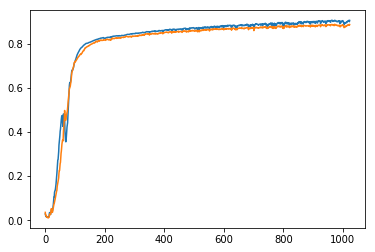

In [62]:
# plot losses
# plt.plot(modelTabnet.history['loss'])

# Plot development of cpc

plt.plot(modelTabnet.history['train_cpc'])
plt.plot(modelTabnet.history['valid_cpc'])

## Training Models - 2. Artificial Neural Network (ANN)  

In [30]:
# define ANN model
# @l : loss function to build model
# @size_hidden_layer : the size of all the hidden layers of the ANN 
# @dropout : the dropout of the model
# @n_layer : the number of hidden layers of the model
# @returns : the defined model
def defineANN(n_features = len(features),l=cpc_loss_keras,size_hidden_layer=20,dropout=0.15,n_layer=2):  #l=cpc_loss_keras
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout,input_shape=(n_features,)))
    for i in range(n_layer):
        model.add(Dense(size_hidden_layer, activation='relu', input_shape=(n_features,)))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.002, clipnorm = 2)
    model.compile(optimizer=opt, loss=l, metrics = custom_metrics_keras)
#  model.compile(optimizer='adam'(lr=0.001), loss=l, metrics = custom_metrics_keras)

    return model

In [31]:
modelAnn = defineANN()
#es = EarlyStopping(monitor='val_cpc_keras', mode='max', verbose=1, patience=200)
historyAnn = modelAnn.fit(X_train, y_train, epochs=1000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid))
#historyAnn = modelAnn.fit(X_train, y_train, epochs=2000, batch_size=256, verbose=1, validation_data=(X_valid, y_valid), callbacks=[es])


Epoch 1/1000
78/78 [==============================] - 1s 10ms/step - loss: 0.8167 - mae: 893.0645 - mse: 372692533.2658 - root_mean_squared_error: 17963.6795 - r_squared_keras: -52802194.3165 - cpc_keras: 0.1833 - val_loss: 1.2806 - val_mae: 32.1884 - val_mse: 234655.1719 - val_root_mean_squared_error: 484.4122 - val_r_squared_keras: -33566.0781 - val_cpc_keras: 0.0657
Epoch 2/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.6735 - mae: 70.8190 - mse: 2006653.4417 - root_mean_squared_error: 1311.8678 - r_squared_keras: -306232.7734 - cpc_keras: 0.3266 - val_loss: 0.8578 - val_mae: 47.5922 - val_mse: 340423.7188 - val_root_mean_squared_error: 583.4584 - val_r_squared_keras: -48658.1953 - val_cpc_keras: 0.1764
Epoch 3/1000
78/78 [==============================] - 0s 1ms/step - loss: 1.2227 - mae: 42.5123 - mse: 536369.7854 - root_mean_squared_error: 683.6480 - r_squared_keras: -16221720.4188 - cpc_keras: -0.2227 - val_loss: 1.1759 - val_mae: 50.7415 - val_mse: 22018.66

Epoch 24/1000
78/78 [==============================] - 0s 1ms/step - loss: -1.3238 - mae: 18.9546 - mse: 57814.1217 - root_mean_squared_error: 215.3054 - r_squared_keras: -8047.2780 - cpc_keras: 2.3236 - val_loss: 0.7776 - val_mae: 29.2048 - val_mse: 150896.6562 - val_root_mean_squared_error: 388.4542 - val_r_squared_keras: -21574.4922 - val_cpc_keras: 0.2330
Epoch 25/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.0477 - mae: 25.0001 - mse: 132293.2845 - root_mean_squared_error: 351.8751 - r_squared_keras: -19201.3172 - cpc_keras: 0.9514 - val_loss: 0.1156 - val_mae: 11.3999 - val_mse: 36113.9531 - val_root_mean_squared_error: 190.0367 - val_r_squared_keras: -5163.2871 - val_cpc_keras: 0.8635
Epoch 26/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.7955 - mae: 25.6859 - mse: 106544.4555 - root_mean_squared_error: 303.7509 - r_squared_keras: -15351.6163 - cpc_keras: 0.2045 - val_loss: 0.7198 - val_mae: 20.6858 - val_mse: 58623.7930 - val_root_mea

Epoch 47/1000
78/78 [==============================] - 0s 1ms/step - loss: -0.0760 - mae: 7.1719 - mse: 10683.9751 - root_mean_squared_error: 98.9466 - r_squared_keras: -1516.5269 - cpc_keras: 1.0760 - val_loss: 0.2093 - val_mae: 5.8273 - val_mse: 3803.6355 - val_root_mean_squared_error: 61.6736 - val_r_squared_keras: -542.9423 - val_cpc_keras: 0.7851
Epoch 48/1000
78/78 [==============================] - 0s 1ms/step - loss: 1.2536 - mae: 11.9728 - mse: 32960.2257 - root_mean_squared_error: 176.3072 - r_squared_keras: -4771.4913 - cpc_keras: -0.2533 - val_loss: 0.3818 - val_mae: 3.9734 - val_mse: 1501.1652 - val_root_mean_squared_error: 38.7449 - val_r_squared_keras: -213.7946 - val_cpc_keras: 0.6328
Epoch 49/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.4948 - mae: 6.5145 - mse: 6610.0443 - root_mean_squared_error: 69.4707 - r_squared_keras: -980.6303 - cpc_keras: 0.5052 - val_loss: -11.3613 - val_mae: 3.6074 - val_mse: 689.2943 - val_root_mean_squared_error: 26.

78/78 [==============================] - 0s 1ms/step - loss: -3.8127 - mae: 6.1525 - mse: 2218.0545 - root_mean_squared_error: 46.0791 - r_squared_keras: -325.1612 - cpc_keras: 4.8118 - val_loss: 0.4999 - val_mae: 7.5146 - val_mse: 9564.6729 - val_root_mean_squared_error: 97.7991 - val_r_squared_keras: -1366.3298 - val_cpc_keras: 0.5303
Epoch 71/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.4861 - mae: 4.3594 - mse: 706.4600 - root_mean_squared_error: 25.5767 - r_squared_keras: -99.9644 - cpc_keras: 0.5138 - val_loss: 0.3463 - val_mae: 3.5124 - val_mse: 1209.5308 - val_root_mean_squared_error: 34.7783 - val_r_squared_keras: -172.0989 - val_cpc_keras: 0.6645
Epoch 72/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.4500 - mae: 4.2584 - mse: 2713.6481 - root_mean_squared_error: 50.8420 - r_squared_keras: -424.2261 - cpc_keras: 0.5501 - val_loss: 0.2641 - val_mae: 2.0924 - val_mse: 60.6926 - val_root_mean_squared_error: 7.7905 - val_r_squared_keras

78/78 [==============================] - 0s 1ms/step - loss: -0.2009 - mae: 5.1352 - mse: 5015.2271 - root_mean_squared_error: 67.9511 - r_squared_keras: -736.6110 - cpc_keras: 1.2007 - val_loss: 0.4097 - val_mae: 5.2120 - val_mse: 5253.4111 - val_root_mean_squared_error: 72.4804 - val_r_squared_keras: -750.0216 - val_cpc_keras: 0.6121
Epoch 94/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.4984 - mae: 4.2196 - mse: 1713.0674 - root_mean_squared_error: 39.3538 - r_squared_keras: -244.4914 - cpc_keras: 0.5015 - val_loss: 0.3262 - val_mae: 3.2019 - val_mse: 966.4345 - val_root_mean_squared_error: 31.0875 - val_r_squared_keras: -137.2973 - val_cpc_keras: 0.6869
Epoch 95/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.3297 - mae: 3.8068 - mse: 3050.8717 - root_mean_squared_error: 51.2598 - r_squared_keras: -459.2975 - cpc_keras: 0.6704 - val_loss: 0.4048 - val_mae: 5.2859 - val_mse: 7444.7891 - val_root_mean_squared_error: 86.2832 - val_r_squared_ke

78/78 [==============================] - 0s 1ms/step - loss: 0.2451 - mae: 1.6854 - mse: 58.4163 - root_mean_squared_error: 7.2117 - r_squared_keras: -6.9394 - cpc_keras: 0.7549 - val_loss: 0.2038 - val_mae: 1.4666 - val_mse: 11.1336 - val_root_mean_squared_error: 3.3367 - val_r_squared_keras: -0.6574 - val_cpc_keras: 0.8006
Epoch 117/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.2169 - mae: 1.4032 - mse: 19.0476 - root_mean_squared_error: 4.0247 - r_squared_keras: -1.6570 - cpc_keras: 0.7831 - val_loss: 0.2203 - val_mae: 1.6429 - val_mse: 5.2419 - val_root_mean_squared_error: 2.2895 - val_r_squared_keras: 0.1212 - val_cpc_keras: 0.7806
Epoch 118/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.2159 - mae: 1.4019 - mse: 11.0388 - root_mean_squared_error: 3.2654 - r_squared_keras: -0.5502 - cpc_keras: 0.7841 - val_loss: 0.2291 - val_mae: 1.7464 - val_mse: 8.2671 - val_root_mean_squared_error: 2.8753 - val_r_squared_keras: -0.3117 - val_cpc_keras:

78/78 [==============================] - 0s 1ms/step - loss: 0.1975 - mae: 1.2616 - mse: 3.4753 - root_mean_squared_error: 1.8619 - r_squared_keras: 0.4788 - cpc_keras: 0.8025 - val_loss: 0.2094 - val_mae: 1.5564 - val_mse: 12.6126 - val_root_mean_squared_error: 3.5514 - val_r_squared_keras: -0.8829 - val_cpc_keras: 0.7940
Epoch 141/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.2024 - mae: 1.3006 - mse: 3.2566 - root_mean_squared_error: 1.8042 - r_squared_keras: 0.5071 - cpc_keras: 0.7977 - val_loss: 0.1917 - val_mae: 1.3862 - val_mse: 3.8363 - val_root_mean_squared_error: 1.9586 - val_r_squared_keras: 0.3941 - val_cpc_keras: 0.8116
Epoch 142/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.2023 - mae: 1.2911 - mse: 4.8604 - root_mean_squared_error: 2.1867 - r_squared_keras: 0.2971 - cpc_keras: 0.7977 - val_loss: 0.1935 - val_mae: 1.4061 - val_mse: 21.6201 - val_root_mean_squared_error: 4.6497 - val_r_squared_keras: -2.1401 - val_cpc_keras: 0.81

78/78 [==============================] - 0s 1ms/step - loss: 0.1985 - mae: 1.2908 - mse: 3.8392 - root_mean_squared_error: 1.9567 - r_squared_keras: -8579.9328 - cpc_keras: 0.8012 - val_loss: 0.2122 - val_mae: 1.5789 - val_mse: 3.9273 - val_root_mean_squared_error: 1.9817 - val_r_squared_keras: 0.3409 - val_cpc_keras: 0.7902
Epoch 165/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1982 - mae: 1.2762 - mse: 4.2918 - root_mean_squared_error: 2.0595 - r_squared_keras: 0.3713 - cpc_keras: 0.8018 - val_loss: 0.2030 - val_mae: 1.4533 - val_mse: 3.3744 - val_root_mean_squared_error: 1.8370 - val_r_squared_keras: 0.4412 - val_cpc_keras: 0.8001
Epoch 166/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1956 - mae: 1.2524 - mse: 3.5242 - root_mean_squared_error: 1.8640 - r_squared_keras: 0.4664 - cpc_keras: 0.8044 - val_loss: 0.2020 - val_mae: 1.4952 - val_mse: 5.7724 - val_root_mean_squared_error: 2.4026 - val_r_squared_keras: 0.1041 - val_cpc_keras: 0.80

78/78 [==============================] - 0s 1ms/step - loss: 0.2044 - mae: 1.3211 - mse: 20.5218 - root_mean_squared_error: 4.3157 - r_squared_keras: -2.2929 - cpc_keras: 0.7957 - val_loss: 0.1811 - val_mae: 1.2920 - val_mse: 2.7421 - val_root_mean_squared_error: 1.6559 - val_r_squared_keras: 0.5606 - val_cpc_keras: 0.8225
Epoch 189/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1885 - mae: 1.2090 - mse: 3.0971 - root_mean_squared_error: 1.7578 - r_squared_keras: 0.5506 - cpc_keras: 0.8116 - val_loss: 0.1825 - val_mae: 1.3007 - val_mse: 5.2929 - val_root_mean_squared_error: 2.3006 - val_r_squared_keras: 0.1922 - val_cpc_keras: 0.8205
Epoch 190/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1926 - mae: 1.2313 - mse: 3.1473 - root_mean_squared_error: 1.7732 - r_squared_keras: 0.5289 - cpc_keras: 0.8073 - val_loss: 0.1779 - val_mae: 1.2564 - val_mse: 3.1453 - val_root_mean_squared_error: 1.7735 - val_r_squared_keras: 0.5093 - val_cpc_keras: 0.8256

78/78 [==============================] - 0s 1ms/step - loss: 0.1873 - mae: 1.1939 - mse: 2.9530 - root_mean_squared_error: 1.7181 - r_squared_keras: 0.5600 - cpc_keras: 0.8127 - val_loss: 0.1932 - val_mae: 1.4003 - val_mse: 3.0046 - val_root_mean_squared_error: 1.7334 - val_r_squared_keras: 0.5046 - val_cpc_keras: 0.8090
Epoch 213/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1842 - mae: 1.1746 - mse: 3.3196 - root_mean_squared_error: 1.8142 - r_squared_keras: 0.5071 - cpc_keras: 0.8158 - val_loss: 0.1799 - val_mae: 1.2840 - val_mse: 2.7352 - val_root_mean_squared_error: 1.6539 - val_r_squared_keras: 0.5609 - val_cpc_keras: 0.8234
Epoch 214/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1831 - mae: 1.1555 - mse: 2.8019 - root_mean_squared_error: 1.6734 - r_squared_keras: 0.5723 - cpc_keras: 0.8169 - val_loss: 0.1973 - val_mae: 1.4384 - val_mse: 3.1670 - val_root_mean_squared_error: 1.7796 - val_r_squared_keras: 0.4777 - val_cpc_keras: 0.8050
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1813 - mae: 1.1549 - mse: 2.7819 - root_mean_squared_error: 1.6678 - r_squared_keras: 0.5816 - cpc_keras: 0.8186 - val_loss: 0.1904 - val_mae: 1.3848 - val_mse: 3.0045 - val_root_mean_squared_error: 1.7333 - val_r_squared_keras: 0.4949 - val_cpc_keras: 0.8116
Epoch 237/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1806 - mae: 1.1595 - mse: 2.7339 - root_mean_squared_error: 1.6532 - r_squared_keras: -4560.3441 - cpc_keras: 0.8191 - val_loss: 0.2055 - val_mae: 1.5488 - val_mse: 3.8876 - val_root_mean_squared_error: 1.9717 - val_r_squared_keras: 0.3455 - val_cpc_keras: 0.7959
Epoch 238/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1829 - mae: 1.1739 - mse: 3.4032 - root_mean_squared_error: 1.8382 - r_squared_keras: 0.4949 - cpc_keras: 0.8171 - val_loss: 0.1960 - val_mae: 1.4579 - val_mse: 3.2383 - val_root_mean_squared_error: 1.7995 - val_r_squared_keras: 0.4484 - val_cpc_keras: 0.80

78/78 [==============================] - 0s 1ms/step - loss: 0.1812 - mae: 1.1417 - mse: 3.2247 - root_mean_squared_error: 1.7924 - r_squared_keras: 0.5042 - cpc_keras: 0.8187 - val_loss: 0.1860 - val_mae: 1.3628 - val_mse: 3.0754 - val_root_mean_squared_error: 1.7537 - val_r_squared_keras: 0.4824 - val_cpc_keras: 0.8148
Epoch 261/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1799 - mae: 1.1382 - mse: 3.1746 - root_mean_squared_error: 1.7808 - r_squared_keras: 0.5276 - cpc_keras: 0.8201 - val_loss: 0.1979 - val_mae: 1.4900 - val_mse: 9.9055 - val_root_mean_squared_error: 3.1473 - val_r_squared_keras: -0.4993 - val_cpc_keras: 0.8038
Epoch 262/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1872 - mae: 1.2186 - mse: 10.7384 - root_mean_squared_error: 3.0541 - r_squared_keras: -0.6371 - cpc_keras: 0.8129 - val_loss: 0.1744 - val_mae: 1.2622 - val_mse: 3.5335 - val_root_mean_squared_error: 1.8797 - val_r_squared_keras: 0.4356 - val_cpc_keras: 0.827

78/78 [==============================] - 0s 1ms/step - loss: 0.1761 - mae: 1.1228 - mse: 2.7716 - root_mean_squared_error: 1.6641 - r_squared_keras: 0.5865 - cpc_keras: 0.8239 - val_loss: 0.1985 - val_mae: 1.4806 - val_mse: 3.4416 - val_root_mean_squared_error: 1.8551 - val_r_squared_keras: 0.4068 - val_cpc_keras: 0.8027
Epoch 285/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1786 - mae: 1.1357 - mse: 3.5288 - root_mean_squared_error: 1.8683 - r_squared_keras: 0.4696 - cpc_keras: 0.8214 - val_loss: 0.1976 - val_mae: 1.5016 - val_mse: 3.9960 - val_root_mean_squared_error: 1.9990 - val_r_squared_keras: 0.3066 - val_cpc_keras: 0.8022
Epoch 286/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1776 - mae: 1.1386 - mse: 4.9124 - root_mean_squared_error: 2.1867 - r_squared_keras: 0.2729 - cpc_keras: 0.8223 - val_loss: 0.1878 - val_mae: 1.3829 - val_mse: 3.0070 - val_root_mean_squared_error: 1.7341 - val_r_squared_keras: 0.4756 - val_cpc_keras: 0.8128
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1719 - mae: 1.0824 - mse: 2.5750 - root_mean_squared_error: 1.6043 - r_squared_keras: 0.6115 - cpc_keras: 0.8281 - val_loss: 0.1753 - val_mae: 1.2834 - val_mse: 6.5252 - val_root_mean_squared_error: 2.5545 - val_r_squared_keras: 0.0107 - val_cpc_keras: 0.8271
Epoch 309/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1733 - mae: 1.0925 - mse: 2.4840 - root_mean_squared_error: 1.5757 - r_squared_keras: 0.6233 - cpc_keras: 0.8267 - val_loss: 0.2165 - val_mae: 1.6926 - val_mse: 4.2041 - val_root_mean_squared_error: 2.0504 - val_r_squared_keras: 0.2565 - val_cpc_keras: 0.7836
Epoch 310/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1789 - mae: 1.1565 - mse: 3.2956 - root_mean_squared_error: 1.8074 - r_squared_keras: 0.5090 - cpc_keras: 0.8212 - val_loss: 0.2018 - val_mae: 1.5335 - val_mse: 3.6715 - val_root_mean_squared_error: 1.9161 - val_r_squared_keras: 0.3610 - val_cpc_keras: 0.7986
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1714 - mae: 1.0776 - mse: 2.3621 - root_mean_squared_error: 1.5368 - r_squared_keras: 0.6422 - cpc_keras: 0.8286 - val_loss: 0.1777 - val_mae: 1.2950 - val_mse: 2.6561 - val_root_mean_squared_error: 1.6298 - val_r_squared_keras: 0.5488 - val_cpc_keras: 0.8235
Epoch 333/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1684 - mae: 1.0657 - mse: 2.4231 - root_mean_squared_error: 1.5565 - r_squared_keras: 0.6315 - cpc_keras: 0.8316 - val_loss: 0.1915 - val_mae: 1.4412 - val_mse: 3.1822 - val_root_mean_squared_error: 1.7839 - val_r_squared_keras: 0.4403 - val_cpc_keras: 0.8083
Epoch 334/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1697 - mae: 1.0773 - mse: 2.4172 - root_mean_squared_error: 1.5539 - r_squared_keras: 0.6331 - cpc_keras: 0.8303 - val_loss: 0.1923 - val_mae: 1.4447 - val_mse: 3.2580 - val_root_mean_squared_error: 1.8050 - val_r_squared_keras: 0.4293 - val_cpc_keras: 0.8079
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1709 - mae: 1.0844 - mse: 2.3954 - root_mean_squared_error: 1.5477 - r_squared_keras: 0.6376 - cpc_keras: 0.8290 - val_loss: 0.1629 - val_mae: 1.1636 - val_mse: 2.2810 - val_root_mean_squared_error: 1.5103 - val_r_squared_keras: 0.6185 - val_cpc_keras: 0.8390
Epoch 357/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1705 - mae: 1.0609 - mse: 2.3525 - root_mean_squared_error: 1.5334 - r_squared_keras: 0.6400 - cpc_keras: 0.8293 - val_loss: 0.2110 - val_mae: 1.6404 - val_mse: 4.0207 - val_root_mean_squared_error: 2.0052 - val_r_squared_keras: 0.2954 - val_cpc_keras: 0.7886
Epoch 358/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1709 - mae: 1.0817 - mse: 2.3370 - root_mean_squared_error: 1.5285 - r_squared_keras: 0.6516 - cpc_keras: 0.8290 - val_loss: 0.1853 - val_mae: 1.3785 - val_mse: 2.9982 - val_root_mean_squared_error: 1.7315 - val_r_squared_keras: 0.4685 - val_cpc_keras: 0.8143
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1677 - mae: 1.0657 - mse: 2.3477 - root_mean_squared_error: 1.5320 - r_squared_keras: 0.6484 - cpc_keras: 0.8323 - val_loss: 0.1829 - val_mae: 1.3553 - val_mse: 2.8233 - val_root_mean_squared_error: 1.6803 - val_r_squared_keras: 0.5128 - val_cpc_keras: 0.8178
Epoch 381/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1686 - mae: 1.0684 - mse: 2.3708 - root_mean_squared_error: 1.5395 - r_squared_keras: -12887.5862 - cpc_keras: 0.8311 - val_loss: 0.2054 - val_mae: 1.5784 - val_mse: 3.6499 - val_root_mean_squared_error: 1.9105 - val_r_squared_keras: 0.3546 - val_cpc_keras: 0.7943
Epoch 382/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1667 - mae: 1.0447 - mse: 2.2402 - root_mean_squared_error: 1.4965 - r_squared_keras: 0.6575 - cpc_keras: 0.8334 - val_loss: 0.2092 - val_mae: 1.6178 - val_mse: 3.7454 - val_root_mean_squared_error: 1.9353 - val_r_squared_keras: 0.3083 - val_cpc_keras: 0.7

78/78 [==============================] - 0s 1ms/step - loss: 0.1669 - mae: 1.0590 - mse: 2.3755 - root_mean_squared_error: 1.5410 - r_squared_keras: 0.6419 - cpc_keras: 0.8330 - val_loss: 0.1923 - val_mae: 1.4459 - val_mse: 3.2008 - val_root_mean_squared_error: 1.7891 - val_r_squared_keras: 0.4557 - val_cpc_keras: 0.8090
Epoch 405/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1680 - mae: 1.0567 - mse: 2.3137 - root_mean_squared_error: 1.5210 - r_squared_keras: 0.6511 - cpc_keras: 0.8320 - val_loss: 0.2028 - val_mae: 1.5619 - val_mse: 3.6083 - val_root_mean_squared_error: 1.8996 - val_r_squared_keras: 0.3581 - val_cpc_keras: 0.7966
Epoch 406/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1645 - mae: 1.0416 - mse: 2.2530 - root_mean_squared_error: 1.5009 - r_squared_keras: 0.6582 - cpc_keras: 0.8355 - val_loss: 0.1905 - val_mae: 1.4355 - val_mse: 3.1339 - val_root_mean_squared_error: 1.7703 - val_r_squared_keras: 0.4557 - val_cpc_keras: 0.8099
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1647 - mae: 1.0365 - mse: 2.2729 - root_mean_squared_error: 1.5075 - r_squared_keras: 0.6585 - cpc_keras: 0.8352 - val_loss: 0.2001 - val_mae: 1.5334 - val_mse: 3.4488 - val_root_mean_squared_error: 1.8571 - val_r_squared_keras: 0.4075 - val_cpc_keras: 0.8003
Epoch 429/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1669 - mae: 1.0415 - mse: 2.2721 - root_mean_squared_error: 1.5072 - r_squared_keras: 0.6579 - cpc_keras: 0.8331 - val_loss: 0.1874 - val_mae: 1.4144 - val_mse: 3.1154 - val_root_mean_squared_error: 1.7650 - val_r_squared_keras: 0.4512 - val_cpc_keras: 0.8120
Epoch 430/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1666 - mae: 1.0576 - mse: 2.3174 - root_mean_squared_error: 1.5222 - r_squared_keras: 0.6354 - cpc_keras: 0.8334 - val_loss: 0.1983 - val_mae: 1.5088 - val_mse: 3.3368 - val_root_mean_squared_error: 1.8267 - val_r_squared_keras: 0.4214 - val_cpc_keras: 0.8024
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1641 - mae: 1.0358 - mse: 2.2802 - root_mean_squared_error: 1.5100 - r_squared_keras: 0.6542 - cpc_keras: 0.8360 - val_loss: 0.1823 - val_mae: 1.3532 - val_mse: 2.8095 - val_root_mean_squared_error: 1.6762 - val_r_squared_keras: 0.5176 - val_cpc_keras: 0.8187
Epoch 453/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1674 - mae: 1.0590 - mse: 2.3255 - root_mean_squared_error: 1.5248 - r_squared_keras: 0.6508 - cpc_keras: 0.8326 - val_loss: 0.1975 - val_mae: 1.5150 - val_mse: 3.4473 - val_root_mean_squared_error: 1.8567 - val_r_squared_keras: 0.3840 - val_cpc_keras: 0.8017
Epoch 454/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1636 - mae: 1.0357 - mse: 2.2825 - root_mean_squared_error: 1.5105 - r_squared_keras: 0.6594 - cpc_keras: 0.8364 - val_loss: 0.1990 - val_mae: 1.5383 - val_mse: 3.5247 - val_root_mean_squared_error: 1.8774 - val_r_squared_keras: 0.3885 - val_cpc_keras: 0.8016
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1651 - mae: 1.0511 - mse: 2.2924 - root_mean_squared_error: 1.5135 - r_squared_keras: 0.6527 - cpc_keras: 0.8348 - val_loss: 0.1855 - val_mae: 1.3949 - val_mse: 3.0292 - val_root_mean_squared_error: 1.7405 - val_r_squared_keras: 0.4672 - val_cpc_keras: 0.8146
Epoch 477/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1659 - mae: 1.0453 - mse: 2.2389 - root_mean_squared_error: 1.4961 - r_squared_keras: 0.6630 - cpc_keras: 0.8341 - val_loss: 0.2006 - val_mae: 1.5367 - val_mse: 3.5311 - val_root_mean_squared_error: 1.8791 - val_r_squared_keras: 0.3695 - val_cpc_keras: 0.7987
Epoch 478/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1656 - mae: 1.0467 - mse: 2.2817 - root_mean_squared_error: 1.5104 - r_squared_keras: 0.6547 - cpc_keras: 0.8344 - val_loss: 0.2160 - val_mae: 1.7044 - val_mse: 4.1996 - val_root_mean_squared_error: 2.0493 - val_r_squared_keras: 0.2523 - val_cpc_keras: 0.7832
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1659 - mae: 1.0466 - mse: 2.2689 - root_mean_squared_error: 1.5062 - r_squared_keras: 0.6596 - cpc_keras: 0.8341 - val_loss: 0.2128 - val_mae: 1.6731 - val_mse: 3.9711 - val_root_mean_squared_error: 1.9928 - val_r_squared_keras: 0.2937 - val_cpc_keras: 0.7865
Epoch 501/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1636 - mae: 1.0361 - mse: 2.2410 - root_mean_squared_error: 1.4968 - r_squared_keras: 0.6631 - cpc_keras: 0.8364 - val_loss: 0.1673 - val_mae: 1.1862 - val_mse: 2.3219 - val_root_mean_squared_error: 1.5238 - val_r_squared_keras: 0.6015 - val_cpc_keras: 0.8341
Epoch 502/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1767 - mae: 1.1052 - mse: 2.5049 - root_mean_squared_error: 1.5816 - r_squared_keras: 0.6252 - cpc_keras: 0.8234 - val_loss: 0.1855 - val_mae: 1.3805 - val_mse: 2.9068 - val_root_mean_squared_error: 1.7049 - val_r_squared_keras: 0.4711 - val_cpc_keras: 0.8133
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1638 - mae: 1.0270 - mse: 2.2241 - root_mean_squared_error: 1.4913 - r_squared_keras: 0.6644 - cpc_keras: 0.8361 - val_loss: 0.2078 - val_mae: 1.6169 - val_mse: 3.6941 - val_root_mean_squared_error: 1.9220 - val_r_squared_keras: 0.3630 - val_cpc_keras: 0.7930
Epoch 525/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1669 - mae: 1.0556 - mse: 2.3101 - root_mean_squared_error: 1.5198 - r_squared_keras: 0.6519 - cpc_keras: 0.8331 - val_loss: 0.2120 - val_mae: 1.6649 - val_mse: 4.0760 - val_root_mean_squared_error: 2.0189 - val_r_squared_keras: 0.2562 - val_cpc_keras: 0.7867
Epoch 526/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1657 - mae: 1.0462 - mse: 2.2699 - root_mean_squared_error: 1.5066 - r_squared_keras: 0.6477 - cpc_keras: 0.8341 - val_loss: 0.1913 - val_mae: 1.4526 - val_mse: 3.1259 - val_root_mean_squared_error: 1.7680 - val_r_squared_keras: 0.4598 - val_cpc_keras: 0.8094
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1683 - mae: 1.0650 - mse: 2.3440 - root_mean_squared_error: 1.5309 - r_squared_keras: 0.6483 - cpc_keras: 0.8316 - val_loss: 0.1897 - val_mae: 1.4288 - val_mse: 3.1449 - val_root_mean_squared_error: 1.7734 - val_r_squared_keras: 0.4553 - val_cpc_keras: 0.8115
Epoch 549/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1646 - mae: 1.0509 - mse: 2.3079 - root_mean_squared_error: 1.5191 - r_squared_keras: 0.6451 - cpc_keras: 0.8354 - val_loss: 0.1923 - val_mae: 1.4528 - val_mse: 3.2015 - val_root_mean_squared_error: 1.7893 - val_r_squared_keras: 0.4397 - val_cpc_keras: 0.8080
Epoch 550/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1649 - mae: 1.0522 - mse: 2.2700 - root_mean_squared_error: 1.5065 - r_squared_keras: 0.6599 - cpc_keras: 0.8351 - val_loss: 0.1620 - val_mae: 1.1615 - val_mse: 2.2982 - val_root_mean_squared_error: 1.5160 - val_r_squared_keras: 0.6168 - val_cpc_keras: 0.8399
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1668 - mae: 1.0577 - mse: 2.3058 - root_mean_squared_error: 1.5182 - r_squared_keras: 0.6497 - cpc_keras: 0.8333 - val_loss: 0.2005 - val_mae: 1.5415 - val_mse: 3.4933 - val_root_mean_squared_error: 1.8690 - val_r_squared_keras: 0.3713 - val_cpc_keras: 0.7985
Epoch 573/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1656 - mae: 1.0458 - mse: 2.2764 - root_mean_squared_error: 1.5088 - r_squared_keras: 0.6335 - cpc_keras: 0.8343 - val_loss: 0.1936 - val_mae: 1.4692 - val_mse: 3.2429 - val_root_mean_squared_error: 1.8008 - val_r_squared_keras: 0.4310 - val_cpc_keras: 0.8067
Epoch 574/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1631 - mae: 1.0413 - mse: 2.2366 - root_mean_squared_error: 1.4954 - r_squared_keras: 0.6638 - cpc_keras: 0.8369 - val_loss: 0.2165 - val_mae: 1.7118 - val_mse: 4.1808 - val_root_mean_squared_error: 2.0447 - val_r_squared_keras: 0.2540 - val_cpc_keras: 0.7831
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1662 - mae: 1.0569 - mse: 2.2674 - root_mean_squared_error: 1.5057 - r_squared_keras: 0.6554 - cpc_keras: 0.8338 - val_loss: 0.1955 - val_mae: 1.4983 - val_mse: 3.2930 - val_root_mean_squared_error: 1.8147 - val_r_squared_keras: 0.4246 - val_cpc_keras: 0.8052
Epoch 597/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1632 - mae: 1.0367 - mse: 2.2668 - root_mean_squared_error: 1.5054 - r_squared_keras: 0.6608 - cpc_keras: 0.8368 - val_loss: 0.1870 - val_mae: 1.4031 - val_mse: 2.9846 - val_root_mean_squared_error: 1.7276 - val_r_squared_keras: 0.4874 - val_cpc_keras: 0.8143
Epoch 598/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1658 - mae: 1.0492 - mse: 2.6522 - root_mean_squared_error: 1.6257 - r_squared_keras: 0.5950 - cpc_keras: 0.8342 - val_loss: 0.2086 - val_mae: 1.6257 - val_mse: 3.7713 - val_root_mean_squared_error: 1.9420 - val_r_squared_keras: 0.3161 - val_cpc_keras: 0.7905
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1629 - mae: 1.0236 - mse: 2.2204 - root_mean_squared_error: 1.4900 - r_squared_keras: 0.6605 - cpc_keras: 0.8370 - val_loss: 0.1762 - val_mae: 1.3064 - val_mse: 2.8041 - val_root_mean_squared_error: 1.6745 - val_r_squared_keras: 0.5113 - val_cpc_keras: 0.8244
Epoch 621/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1676 - mae: 1.0672 - mse: 2.3777 - root_mean_squared_error: 1.5417 - r_squared_keras: 0.6428 - cpc_keras: 0.8324 - val_loss: 0.1895 - val_mae: 1.4294 - val_mse: 3.0614 - val_root_mean_squared_error: 1.7497 - val_r_squared_keras: 0.4752 - val_cpc_keras: 0.8116
Epoch 622/1000
78/78 [==============================] - 0s 2ms/step - loss: 0.1672 - mae: 1.0553 - mse: 2.3120 - root_mean_squared_error: 1.5205 - r_squared_keras: 0.6054 - cpc_keras: 0.8328 - val_loss: 0.2057 - val_mae: 1.5953 - val_mse: 3.7415 - val_root_mean_squared_error: 1.9343 - val_r_squared_keras: 0.3184 - val_cpc_keras: 0.7929
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1620 - mae: 1.0299 - mse: 2.1975 - root_mean_squared_error: 1.4821 - r_squared_keras: 0.6719 - cpc_keras: 0.8380 - val_loss: 0.1861 - val_mae: 1.3843 - val_mse: 3.2301 - val_root_mean_squared_error: 1.7972 - val_r_squared_keras: 0.4293 - val_cpc_keras: 0.8155
Epoch 645/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1648 - mae: 1.0438 - mse: 2.3258 - root_mean_squared_error: 1.5247 - r_squared_keras: -482.1497 - cpc_keras: 0.8352 - val_loss: 0.1995 - val_mae: 1.5404 - val_mse: 3.4907 - val_root_mean_squared_error: 1.8683 - val_r_squared_keras: 0.3615 - val_cpc_keras: 0.7992
Epoch 646/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1645 - mae: 1.0303 - mse: 2.2414 - root_mean_squared_error: 1.4971 - r_squared_keras: 0.6608 - cpc_keras: 0.8356 - val_loss: 0.1989 - val_mae: 1.5357 - val_mse: 3.5229 - val_root_mean_squared_error: 1.8769 - val_r_squared_keras: 0.3596 - val_cpc_keras: 0.800

78/78 [==============================] - 0s 2ms/step - loss: 0.1679 - mae: 1.0631 - mse: 2.3293 - root_mean_squared_error: 1.5260 - r_squared_keras: 0.6455 - cpc_keras: 0.8321 - val_loss: 0.1744 - val_mae: 1.2954 - val_mse: 2.6935 - val_root_mean_squared_error: 1.6412 - val_r_squared_keras: 0.5253 - val_cpc_keras: 0.8264
Epoch 669/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1678 - mae: 1.0574 - mse: 2.3435 - root_mean_squared_error: 1.5305 - r_squared_keras: 0.6474 - cpc_keras: 0.8322 - val_loss: 0.2121 - val_mae: 1.6677 - val_mse: 4.0481 - val_root_mean_squared_error: 2.0120 - val_r_squared_keras: 0.3021 - val_cpc_keras: 0.7891
Epoch 670/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1643 - mae: 1.0376 - mse: 2.2522 - root_mean_squared_error: 1.5007 - r_squared_keras: 0.6552 - cpc_keras: 0.8357 - val_loss: 0.2010 - val_mae: 1.5593 - val_mse: 3.5488 - val_root_mean_squared_error: 1.8838 - val_r_squared_keras: 0.3626 - val_cpc_keras: 0.7986
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1628 - mae: 1.0251 - mse: 2.2247 - root_mean_squared_error: 1.4915 - r_squared_keras: 0.6615 - cpc_keras: 0.8370 - val_loss: 0.2361 - val_mae: 1.9176 - val_mse: 5.1309 - val_root_mean_squared_error: 2.2651 - val_r_squared_keras: 0.0642 - val_cpc_keras: 0.7624
Epoch 693/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1719 - mae: 1.0962 - mse: 2.3463 - root_mean_squared_error: 1.5316 - r_squared_keras: 0.6448 - cpc_keras: 0.8281 - val_loss: 0.2049 - val_mae: 1.5840 - val_mse: 3.6021 - val_root_mean_squared_error: 1.8979 - val_r_squared_keras: 0.3574 - val_cpc_keras: 0.7947
Epoch 694/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1615 - mae: 1.0207 - mse: 2.1559 - root_mean_squared_error: 1.4678 - r_squared_keras: 0.6683 - cpc_keras: 0.8383 - val_loss: 0.2052 - val_mae: 1.5984 - val_mse: 3.7238 - val_root_mean_squared_error: 1.9297 - val_r_squared_keras: 0.3405 - val_cpc_keras: 0.7945
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1615 - mae: 1.0216 - mse: 2.2188 - root_mean_squared_error: 1.4895 - r_squared_keras: 0.6652 - cpc_keras: 0.8384 - val_loss: 0.2043 - val_mae: 1.5881 - val_mse: 3.6742 - val_root_mean_squared_error: 1.9168 - val_r_squared_keras: 0.3301 - val_cpc_keras: 0.7945
Epoch 717/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1610 - mae: 1.0193 - mse: 2.1707 - root_mean_squared_error: 1.4731 - r_squared_keras: 0.6726 - cpc_keras: 0.8390 - val_loss: 0.2119 - val_mae: 1.6658 - val_mse: 3.9827 - val_root_mean_squared_error: 1.9957 - val_r_squared_keras: 0.2461 - val_cpc_keras: 0.7857
Epoch 718/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1607 - mae: 1.0277 - mse: 2.2226 - root_mean_squared_error: 1.4908 - r_squared_keras: 0.6630 - cpc_keras: 0.8393 - val_loss: 0.2009 - val_mae: 1.5517 - val_mse: 3.4492 - val_root_mean_squared_error: 1.8572 - val_r_squared_keras: 0.3983 - val_cpc_keras: 0.7995
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1633 - mae: 1.0437 - mse: 2.1857 - root_mean_squared_error: 1.4783 - r_squared_keras: 0.6690 - cpc_keras: 0.8368 - val_loss: 0.2016 - val_mae: 1.5514 - val_mse: 3.4745 - val_root_mean_squared_error: 1.8640 - val_r_squared_keras: 0.3807 - val_cpc_keras: 0.7980
Epoch 741/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1590 - mae: 1.0042 - mse: 2.1028 - root_mean_squared_error: 1.4498 - r_squared_keras: 0.6784 - cpc_keras: 0.8410 - val_loss: 0.2128 - val_mae: 1.6752 - val_mse: 3.9641 - val_root_mean_squared_error: 1.9910 - val_r_squared_keras: 0.2742 - val_cpc_keras: 0.7860
Epoch 742/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1616 - mae: 1.0089 - mse: 2.1276 - root_mean_squared_error: 1.4585 - r_squared_keras: 0.6697 - cpc_keras: 0.8377 - val_loss: 0.2059 - val_mae: 1.6020 - val_mse: 3.6580 - val_root_mean_squared_error: 1.9126 - val_r_squared_keras: 0.3389 - val_cpc_keras: 0.7935
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1615 - mae: 1.0238 - mse: 2.1683 - root_mean_squared_error: 1.4724 - r_squared_keras: 0.6644 - cpc_keras: 0.8386 - val_loss: 0.2082 - val_mae: 1.6271 - val_mse: 3.7493 - val_root_mean_squared_error: 1.9363 - val_r_squared_keras: 0.3451 - val_cpc_keras: 0.7919
Epoch 765/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1655 - mae: 1.0472 - mse: 2.3094 - root_mean_squared_error: 1.5195 - r_squared_keras: 0.6539 - cpc_keras: 0.8345 - val_loss: 0.1799 - val_mae: 1.3455 - val_mse: 2.7396 - val_root_mean_squared_error: 1.6552 - val_r_squared_keras: 0.5428 - val_cpc_keras: 0.8217
Epoch 766/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1655 - mae: 1.0474 - mse: 4.6478 - root_mean_squared_error: 2.1134 - r_squared_keras: 0.3284 - cpc_keras: 0.8344 - val_loss: 0.2032 - val_mae: 1.5667 - val_mse: 3.4999 - val_root_mean_squared_error: 1.8708 - val_r_squared_keras: 0.3791 - val_cpc_keras: 0.7970
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1646 - mae: 1.0329 - mse: 2.8403 - root_mean_squared_error: 1.6665 - r_squared_keras: 0.5688 - cpc_keras: 0.8353 - val_loss: 0.2204 - val_mae: 1.7471 - val_mse: 4.2483 - val_root_mean_squared_error: 2.0611 - val_r_squared_keras: 0.2290 - val_cpc_keras: 0.7780
Epoch 789/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1649 - mae: 1.0474 - mse: 2.2482 - root_mean_squared_error: 1.4993 - r_squared_keras: 0.6552 - cpc_keras: 0.8351 - val_loss: 0.2211 - val_mae: 1.7648 - val_mse: 4.3293 - val_root_mean_squared_error: 2.0807 - val_r_squared_keras: 0.2370 - val_cpc_keras: 0.7783
Epoch 790/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1653 - mae: 1.0546 - mse: 2.3591 - root_mean_squared_error: 1.5355 - r_squared_keras: 0.6446 - cpc_keras: 0.8346 - val_loss: 0.1841 - val_mae: 1.3823 - val_mse: 2.8664 - val_root_mean_squared_error: 1.6930 - val_r_squared_keras: 0.5132 - val_cpc_keras: 0.8172
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1607 - mae: 1.0242 - mse: 2.1603 - root_mean_squared_error: 1.4697 - r_squared_keras: 0.6764 - cpc_keras: 0.8393 - val_loss: 0.2106 - val_mae: 1.6542 - val_mse: 3.8925 - val_root_mean_squared_error: 1.9729 - val_r_squared_keras: 0.3087 - val_cpc_keras: 0.7893
Epoch 813/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1615 - mae: 1.0175 - mse: 2.1566 - root_mean_squared_error: 1.4684 - r_squared_keras: 0.6678 - cpc_keras: 0.8384 - val_loss: 0.1861 - val_mae: 1.4031 - val_mse: 2.9823 - val_root_mean_squared_error: 1.7269 - val_r_squared_keras: 0.4853 - val_cpc_keras: 0.8146
Epoch 814/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1603 - mae: 1.0092 - mse: 2.1563 - root_mean_squared_error: 1.4683 - r_squared_keras: 0.6718 - cpc_keras: 0.8397 - val_loss: 0.1996 - val_mae: 1.5387 - val_mse: 3.3382 - val_root_mean_squared_error: 1.8271 - val_r_squared_keras: 0.4174 - val_cpc_keras: 0.8005
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1607 - mae: 1.0133 - mse: 2.1700 - root_mean_squared_error: 1.4731 - r_squared_keras: 0.6736 - cpc_keras: 0.8394 - val_loss: 0.2032 - val_mae: 1.5680 - val_mse: 3.5058 - val_root_mean_squared_error: 1.8724 - val_r_squared_keras: 0.3583 - val_cpc_keras: 0.7950
Epoch 837/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1646 - mae: 1.0433 - mse: 2.3373 - root_mean_squared_error: 1.5284 - r_squared_keras: 0.6345 - cpc_keras: 0.8352 - val_loss: 0.2041 - val_mae: 1.5825 - val_mse: 3.6169 - val_root_mean_squared_error: 1.9018 - val_r_squared_keras: 0.3694 - val_cpc_keras: 0.7961
Epoch 838/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1659 - mae: 1.0473 - mse: 2.3282 - root_mean_squared_error: 1.5252 - r_squared_keras: 0.6469 - cpc_keras: 0.8340 - val_loss: 0.1740 - val_mae: 1.2846 - val_mse: 2.5441 - val_root_mean_squared_error: 1.5950 - val_r_squared_keras: 0.5837 - val_cpc_keras: 0.8287
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1618 - mae: 1.0172 - mse: 2.1901 - root_mean_squared_error: 1.4798 - r_squared_keras: 0.6691 - cpc_keras: 0.8382 - val_loss: 0.1764 - val_mae: 1.3108 - val_mse: 2.6475 - val_root_mean_squared_error: 1.6271 - val_r_squared_keras: 0.5695 - val_cpc_keras: 0.8263
Epoch 861/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1631 - mae: 1.0283 - mse: 2.2225 - root_mean_squared_error: 1.4907 - r_squared_keras: 0.6681 - cpc_keras: 0.8369 - val_loss: 0.1935 - val_mae: 1.4737 - val_mse: 3.1285 - val_root_mean_squared_error: 1.7688 - val_r_squared_keras: 0.4703 - val_cpc_keras: 0.8077
Epoch 862/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1634 - mae: 1.0313 - mse: 2.2341 - root_mean_squared_error: 1.4946 - r_squared_keras: 0.6604 - cpc_keras: 0.8367 - val_loss: 0.1841 - val_mae: 1.3728 - val_mse: 2.8677 - val_root_mean_squared_error: 1.6934 - val_r_squared_keras: 0.5215 - val_cpc_keras: 0.8179
E

78/78 [==============================] - 0s 2ms/step - loss: 0.1597 - mae: 1.0150 - mse: 2.2194 - root_mean_squared_error: 1.4896 - r_squared_keras: 0.6695 - cpc_keras: 0.8403 - val_loss: 0.2260 - val_mae: 1.7492 - val_mse: 10.6238 - val_root_mean_squared_error: 3.2594 - val_r_squared_keras: -0.6623 - val_cpc_keras: 0.7745
Epoch 885/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1782 - mae: 1.1128 - mse: 12.0896 - root_mean_squared_error: 3.0626 - r_squared_keras: -591.5597 - cpc_keras: 0.8215 - val_loss: 0.2238 - val_mae: 1.6419 - val_mse: 25.8303 - val_root_mean_squared_error: 5.0824 - val_r_squared_keras: -2.7793 - val_cpc_keras: 0.7798
Epoch 886/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1786 - mae: 1.0986 - mse: 20.5550 - root_mean_squared_error: 3.9047 - r_squared_keras: -1.9016 - cpc_keras: 0.8214 - val_loss: 0.1950 - val_mae: 1.4454 - val_mse: 3.4100 - val_root_mean_squared_error: 1.8466 - val_r_squared_keras: 0.4146 - val_cpc_keras

78/78 [==============================] - 0s 1ms/step - loss: 0.1582 - mae: 1.0097 - mse: 2.1600 - root_mean_squared_error: 1.4696 - r_squared_keras: 0.6762 - cpc_keras: 0.8418 - val_loss: 0.2004 - val_mae: 1.5373 - val_mse: 3.4449 - val_root_mean_squared_error: 1.8561 - val_r_squared_keras: 0.3949 - val_cpc_keras: 0.7994
Epoch 909/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1607 - mae: 1.0145 - mse: 2.1599 - root_mean_squared_error: 1.4695 - r_squared_keras: 0.6349 - cpc_keras: 0.8393 - val_loss: 0.1910 - val_mae: 1.4484 - val_mse: 3.0448 - val_root_mean_squared_error: 1.7449 - val_r_squared_keras: 0.4932 - val_cpc_keras: 0.8109
Epoch 910/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1601 - mae: 1.0138 - mse: 2.1789 - root_mean_squared_error: 1.4760 - r_squared_keras: 0.6700 - cpc_keras: 0.8399 - val_loss: 0.2088 - val_mae: 1.6319 - val_mse: 3.7465 - val_root_mean_squared_error: 1.9356 - val_r_squared_keras: 0.3329 - val_cpc_keras: 0.7903
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1602 - mae: 1.0197 - mse: 2.1700 - root_mean_squared_error: 1.4730 - r_squared_keras: 0.6602 - cpc_keras: 0.8396 - val_loss: 0.2108 - val_mae: 1.6530 - val_mse: 3.8253 - val_root_mean_squared_error: 1.9558 - val_r_squared_keras: 0.3318 - val_cpc_keras: 0.7892
Epoch 933/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1601 - mae: 1.0098 - mse: 2.1928 - root_mean_squared_error: 1.4802 - r_squared_keras: 0.6728 - cpc_keras: 0.8400 - val_loss: 0.1978 - val_mae: 1.5168 - val_mse: 3.2872 - val_root_mean_squared_error: 1.8131 - val_r_squared_keras: 0.4103 - val_cpc_keras: 0.8014
Epoch 934/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1598 - mae: 1.0069 - mse: 2.1302 - root_mean_squared_error: 1.4593 - r_squared_keras: 0.6769 - cpc_keras: 0.8401 - val_loss: 0.2036 - val_mae: 1.5775 - val_mse: 3.5008 - val_root_mean_squared_error: 1.8710 - val_r_squared_keras: 0.3692 - val_cpc_keras: 0.7951
E

78/78 [==============================] - 0s 1ms/step - loss: 0.1626 - mae: 1.0382 - mse: 2.2033 - root_mean_squared_error: 1.4841 - r_squared_keras: 0.6660 - cpc_keras: 0.8373 - val_loss: 0.1968 - val_mae: 1.4989 - val_mse: 3.2195 - val_root_mean_squared_error: 1.7943 - val_r_squared_keras: 0.4406 - val_cpc_keras: 0.8038
Epoch 957/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1588 - mae: 1.0106 - mse: 2.1352 - root_mean_squared_error: 1.4609 - r_squared_keras: 0.6798 - cpc_keras: 0.8412 - val_loss: 0.2130 - val_mae: 1.6792 - val_mse: 3.8634 - val_root_mean_squared_error: 1.9655 - val_r_squared_keras: 0.3226 - val_cpc_keras: 0.7870
Epoch 958/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1659 - mae: 1.0714 - mse: 25.8864 - root_mean_squared_error: 4.7360 - r_squared_keras: -2.5748 - cpc_keras: 0.8340 - val_loss: 0.2150 - val_mae: 1.6978 - val_mse: 3.9234 - val_root_mean_squared_error: 1.9808 - val_r_squared_keras: 0.2931 - val_cpc_keras: 0.7837

78/78 [==============================] - 0s 1ms/step - loss: 0.1620 - mae: 1.0142 - mse: 2.1967 - root_mean_squared_error: 1.4819 - r_squared_keras: 0.4077 - cpc_keras: 0.8380 - val_loss: 0.2012 - val_mae: 1.5521 - val_mse: 3.5169 - val_root_mean_squared_error: 1.8753 - val_r_squared_keras: 0.3810 - val_cpc_keras: 0.7986
Epoch 981/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1580 - mae: 1.0049 - mse: 2.1633 - root_mean_squared_error: 1.4706 - r_squared_keras: 0.6709 - cpc_keras: 0.8420 - val_loss: 0.2228 - val_mae: 1.7829 - val_mse: 4.3112 - val_root_mean_squared_error: 2.0763 - val_r_squared_keras: 0.2064 - val_cpc_keras: 0.7752
Epoch 982/1000
78/78 [==============================] - 0s 1ms/step - loss: 0.1636 - mae: 1.0380 - mse: 2.3041 - root_mean_squared_error: 1.5179 - r_squared_keras: 0.6545 - cpc_keras: 0.8364 - val_loss: 0.1906 - val_mae: 1.4405 - val_mse: 3.0343 - val_root_mean_squared_error: 1.7419 - val_r_squared_keras: 0.4988 - val_cpc_keras: 0.8115
E

In [32]:
historyAnn_loss = historyAnn.history.get('val_cpc_keras')
modelAnn_best_loss = np.max(historyAnn_loss)
modelAnn_best_epoch = historyAnn_loss.index(modelAnn_best_loss)+1

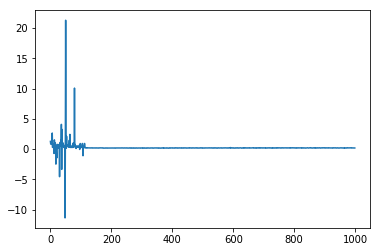

In [33]:
plt.plot(historyAnn.history.get('val_loss'))

In [34]:
print(modelAnn_best_loss, modelAnn_best_epoch)

11.26030158996582 49


## Training Models - 3. Gradient Boosting Trees 

In [35]:
modelXgb = XGBRegressor(max_depth=8,
    learning_rate=0.05,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=random_seed,)

modelXgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=10,)

[0]	validation_0-rmse:3.59346
Will train until validation_0-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.33391
[20]	validation_0-rmse:1.63972
[30]	validation_0-rmse:1.2815
[40]	validation_0-rmse:1.10448
[50]	validation_0-rmse:1.02178
[60]	validation_0-rmse:0.975695
[70]	validation_0-rmse:0.94817
[80]	validation_0-rmse:0.9257
[90]	validation_0-rmse:0.908314
[100]	validation_0-rmse:0.898003
[110]	validation_0-rmse:0.883913
[120]	validation_0-rmse:0.875391
[130]	validation_0-rmse:0.872016
[140]	validation_0-rmse:0.860364
[150]	validation_0-rmse:0.854106
[160]	validation_0-rmse:0.849949
[170]	validation_0-rmse:0.845141
[180]	validation_0-rmse:0.841462
[190]	validation_0-rmse:0.839779
[200]	validation_0-rmse:0.838483
[210]	validation_0-rmse:0.835567
[220]	validation_0-rmse:0.83262
[230]	validation_0-rmse:0.83026
[240]	validation_0-rmse:0.827783
[250]	validation_0-rmse:0.82369
[260]	validation_0-rmse:0.82146
[270]	validation_0-rmse:0.820068
[280]	validation_0-rmse:0.8179
[290]

XGBRegressor(learning_rate=0.05, max_depth=8, n_estimators=1000, n_jobs=-1,
             seed=123, subsample=0.7, verbosity=0)

# Score and evaluate all models

In [63]:
# predictions on test set
y_pred_Ann_test = modelAnn.predict(X_test)
y_pred_Tabnet_test = modelTabnet.predict(X_test)
y_pred_Xgb_test = modelXgb.predict(X_test).reshape(-1,1)

# predictions on train/val set
X_trainval = np.append(X_train, X_valid, axis=0)
y_trainval = np.append(y_train, y_valid, axis=0)

y_pred_Ann_trainval = modelAnn.predict(X_trainval)
y_pred_Tabnet_trainval = modelTabnet.predict(X_trainval)
y_pred_Xgb_trainval = modelXgb.predict(X_trainval).reshape(-1,1)


In [64]:
def eval_performance_allmetrics(y_pred, y_true):
# list of eval metrics ['mae', 'mse', 'rmse', r_squared, CPC]
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_true)
    mse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=True)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_true, squared=False)
    r_squared = r2_score(y_pred=y_pred, y_true=y_true)
    cpc = 2 * np.sum(np.minimum((y_true), y_pred)) / (np.sum(y_true) + np.sum(y_pred))
    return [mae, mse, rmse, r_squared, cpc]

In [65]:
performance_metrics_name = ['mae', 'mse', 'rmse', 'r_squared', 'CPC']

performance_Ann_test = eval_performance_allmetrics(y_pred_Ann_test, y_test)
performance_Tabnet_test = eval_performance_allmetrics(y_pred_Tabnet_test, y_test)
performance_Xgb_test = eval_performance_allmetrics(y_pred_Xgb_test, y_test)

performance_Ann_trainval = eval_performance_allmetrics(y_pred_Ann_trainval, y_trainval)
performance_Tabnet_trainval = eval_performance_allmetrics(y_pred_Tabnet_trainval, y_trainval)
performance_Xgb_trainval = eval_performance_allmetrics(y_pred_Xgb_trainval, y_trainval)

In [66]:
print(performance_Ann_test, performance_Tabnet_test, performance_Xgb_test)

[1.4558223, 3.2512033, 1.8031093, 0.5338926199605911, 0.8159953291890447] [1.3421222, 3.9177947, 1.979342, 0.43832699370819916, 0.7950873185859791] [0.7810428, 1.3260361, 1.1515365, 0.8098934128364432, 0.8828035886721023]


In [67]:
# performance 
df_metric = pd.DataFrame(np.transpose([performance_metrics_name, performance_Ann_test, performance_Tabnet_test, performance_Xgb_test, performance_Ann_trainval, performance_Tabnet_trainval, performance_Xgb_trainval]), columns=["Metrics", "ANN_on_test", "TabNet_on_test", "XGB_on_test", "ANN_on_trainval", "TabNet_on_trainval", "XGB_on_trainval"])

In [68]:
for col in df_metric:
    if col != "Metrics":
        df_metric[col] = df_metric[col].astype("float").map('{:,.4f}'.format)
    
df_metric

,Metrics,ANN_on_test,TabNet_on_test,XGB_on_test,ANN_on_trainval,TabNet_on_trainval,XGB_on_trainval
0,mae,1.4558,1.3421,0.7810,1.3732,0.6080,0.1660
1,mse,3.2512,3.9178,1.3260,2.9395,0.8543,0.0907
2,rmse,1.8031,1.9793,1.1515,1.7145,0.9243,0.3011
3,r_squared,0.5339,0.4383,0.8099,0.5603,0.8722,0.9864
4,CPC,0.8160,0.7951,0.8828,0.8150,0.9051,0.9736


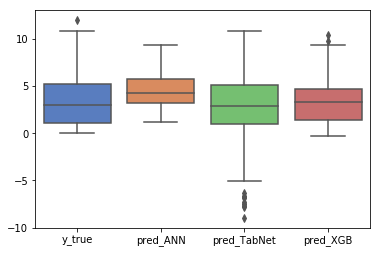

In [69]:
# Range of ground truth versus individual model predicted - BoxPlot
df_pred_test = pd.DataFrame(np.transpose([y_test.flatten(), y_pred_Ann_test.flatten(), y_pred_Tabnet_test.flatten(), y_pred_Xgb_test.flatten()]), columns=["y_true", "pred_ANN", "pred_TabNet", "pred_XGB"])
sns.boxplot(data= df_pred_test, palette="muted")
plt.savefig('./exhibits/variant_features/prediction_comparison.png')

# Model Intepretations

## Shapley result intepretation 

### Calculations for three fitted models 

In [43]:
shap.initjs()

def modelAnn_predictor(X):
    return modelAnn.predict(X).flatten()

def modelTabnet_predictor(X):
    return modelTabnet.predict(X).flatten()

def modelXgb_predictor(X):
    return modelXgb.predict(X).flatten()

# using a fixed subsample to approximate the whole test set
fixed_subsample=shap.sample(X_test,1000)

explainerANN = shap.KernelExplainer(modelAnn_predictor, shap.sample(X_trainval,50))
shap_valuesANN = explainerANN.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerTabnet = shap.KernelExplainer(modelTabnet_predictor, shap.sample(X_trainval,50))
shap_valuesTabnet = explainerTabnet.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

explainerXgb = shap.KernelExplainer(modelXgb_predictor, shap.sample(X_trainval,50))
shap_valuesXgb = explainerXgb.shap_values(fixed_subsample, nsamples=500) #use a random 5000 samples to 

# In theory code below also works, but it runs extremely long
# explainer = shap.KernelExplainer(f, X_trainval)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [44]:
shap_values = shap_valuesTabnet

### Using Shap to create overview summary of relationship between features and target

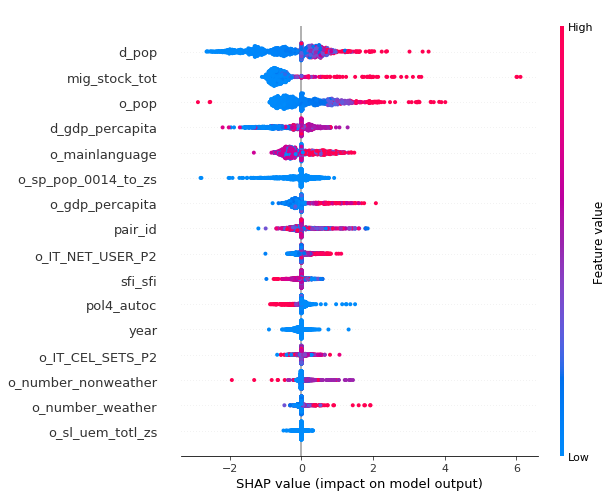

In [45]:
shap.summary_plot(shap_values, fixed_subsample, features, show=False)

### Using Shap to create a variable importance graph

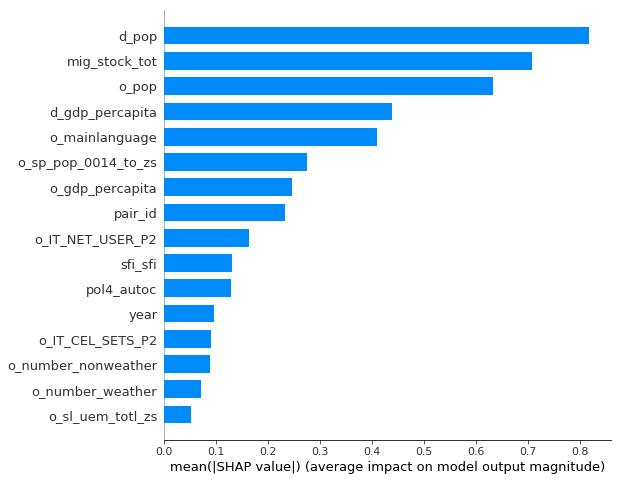

In [46]:
shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)

### Using Shap to create a PDP-like insights

SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The plots show variation in dot color corresponding to presence of suggested interactions.

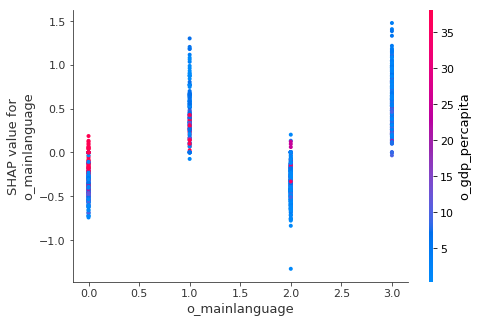

In [55]:
shap.dependence_plot("o_mainlanguage", shap_values, fixed_subsample, features, show=False)

### Using Shap additive force layout

In [49]:
# shap.force_plot(explainer.expected_value, shap_values, features)


### Saving SHAP Exhibits

In [50]:
def generate_shap_Exhibits(shap_values, model, dataset):
    shap.summary_plot(shap_values, fixed_subsample, features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/variant_features/{}_shap_overview.png'.format(model), bbox_inches='tight')
    plt.close()

    shap.summary_plot(shap_values, fixed_subsample, plot_type="bar", feature_names=features, show=False)
    plt.title('{} {} '.format(model, dataset), fontsize=4)
    plt.savefig('./exhibits/variant_features/{}_varimp.png'.format(model), bbox_inches='tight')
    plt.close()

    for f in features:
        shap.dependence_plot(f, shap_values, fixed_subsample, features, show=False)
        plt.title('{} {} '.format(model, dataset), fontsize=4)
        plt.savefig('./exhibits/variant_features/{}_dp_{}.png'.format(model, f), bbox_inches='tight')
        plt.close()


In [51]:
generate_shap_Exhibits(shap_values=shap_valuesXgb, model="XGB", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesANN, model="ANN", dataset="on sampled Test set")
generate_shap_Exhibits(shap_values=shap_valuesTabnet, model="TabNet", dataset="on sampled Test set")




# Interpreting TabNet Results

TabNet [3] is an interpretable deep learning architecture from Google AI that ingests tabular data and leverages the layers that comprise its sequential attention mechanism, providing both decision-step and aggregate-feature importance masks.

In [70]:
explain_matrix, masks = modelTabnet.explain(X_test)


Feature importance masks from a TabNet model show the importance of each feature for the top N samples. Feature importance masks (Mask i indicates feature selection at ith step) showing the global instance-wise feature selection. Brighter colors show a higher value. 

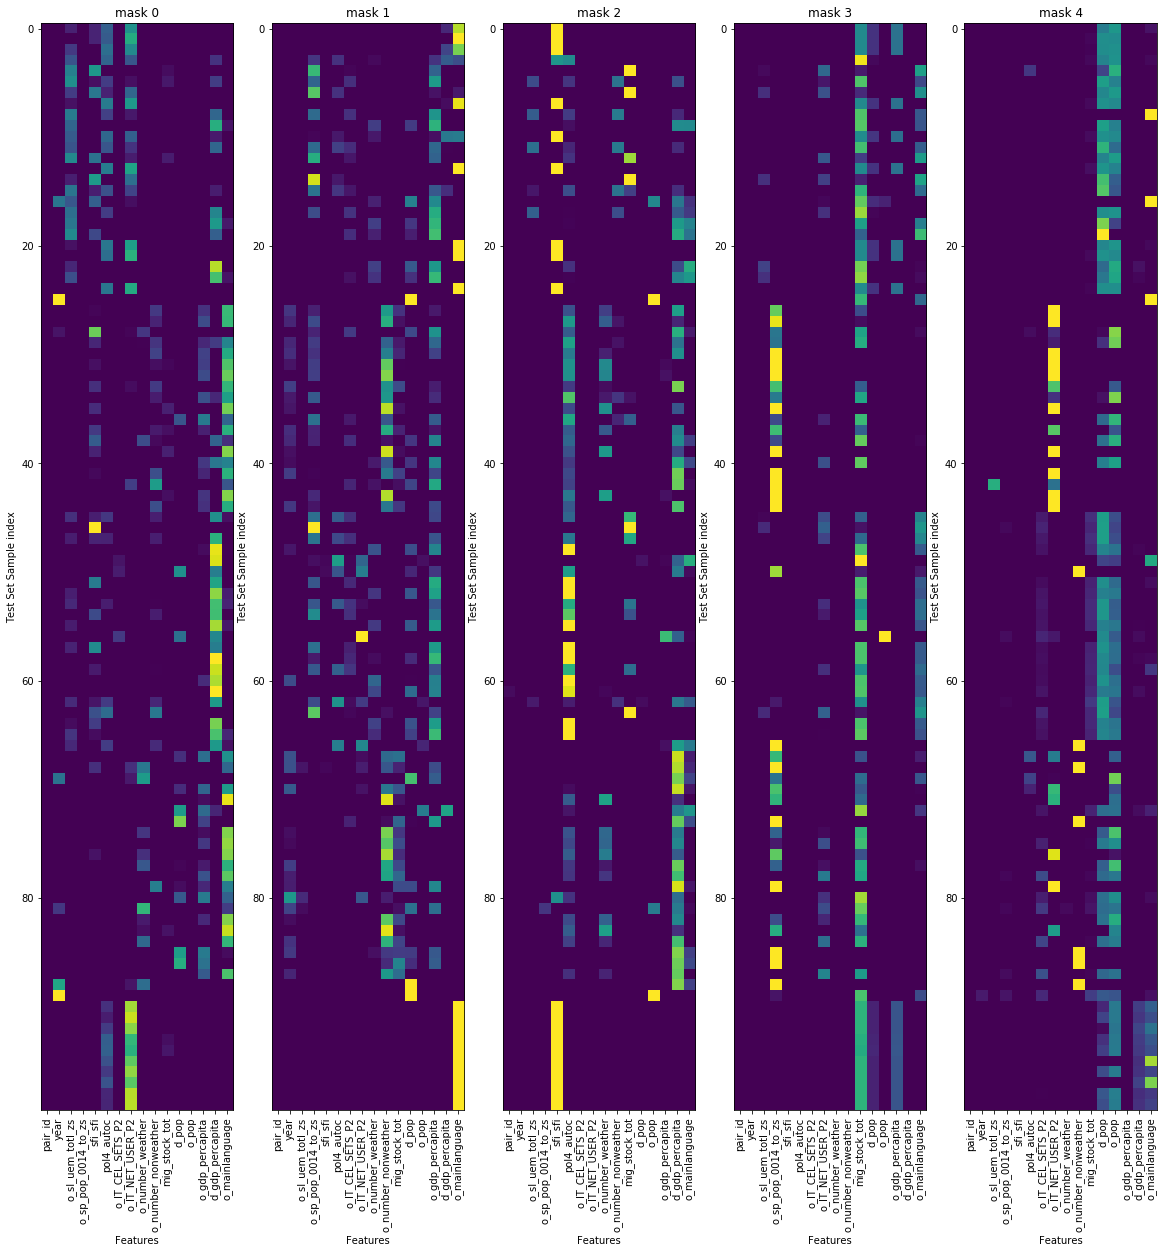

In [71]:
%matplotlib inline
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:100], aspect="auto")
    axs[i].set_title(f"mask {i}")
    axs[i].set_xlabel('Features')
    axs[i].set_ylabel('Test Set Sample index')
    axs[i].xaxis.set_ticks(np.arange(len(features)))
    axs[i].set_xticklabels(features, rotation='vertical')
plt.savefig('./exhibits/variant_features/TabNet_intepretation.png')

## References ##


[1] N. Golenvaux, P. G. Alvarez, H. S. Kiossou and P. Schaus, "An LSTM approach to Predict Migration based on Google Trends" ArXiv, abs/2005.09902. Published 2020.

[2] M. H. Böhme, A. Gröger, and T. Stöhr, “Searching for a better life: Predicting international migration with online search keywords,” Journal of Development Economics, vol. 142, p. 102347, Jan. 2020, doi: 10.1016/j.jdeveco.2019.04.002.

[3] S. O. Arik, and T. Pfister, "TabNet: Attentive Interpretable Tabular Learning". 2019. arXiv preprint arXiv:1908.07442, 2019. URL: https://arxiv.org/pdf/1908.07442.pdf

[4] A. P. Masucci, J. Serras, A. Johansson, and M. Batty, “Gravity versus radiation models: On the importance of scale and heterogeneity in commuting flows,” Physical Review E, vol. 88, no. 2, p. 022812, 2013.

[5] C. Robinson and B. Dilkina, “A machine learning approach to modeling human migration,” in Proceedings of the 1st ACM SIGCAS Conference on Computing and Sustainable Societies, 2018, pp. 1–8.

[6] F. A. Gers, J. Schmidhuber, and F. Cummins, “Learning to Forget: Continual Prediction with LSTM,” Neural Computation, vol. 12, no. 10, pp. 2451–2471, Oct. 2000, doi: 10.1162/089976600300015015.

[7] S. Hochreiter and J. Schmidhuber, “Long short-term memory,” Neural computation, vol. 9, no. 8, pp. 1735–1780, 1997.

[8] C. Molnar, “Interpretable Machine Learning - A Guide for Making Black Box Models Explainable,” https://christophm.github.io/interpretable-ml-book/index.html

[9] International Migration Institute,”Determinants of International Migration (DEMIG) - POLICY data”. 2021.